# Preprocess Tutorial

You have successfully designed a scRNA-seq experiment - you isolated single cells, captured their transcripts, and generated sequencing libraries where the transcripts were mapped to individual cells. Now you have raw data in the form of a counts matrix. So, what do we do with this counts matrix? How can we use this data to start to answer interesting biological questions and even generate new hypotheses?

This series of scRNA-seq tutorials - Preprocess, Cluster Analysis, and Pseudotime Analysis - will take you through a standard scRNA-seq analysis workflow geared toward developmental biologists. Bioinformatics is a big field, and new and exciting methods and advancements are coming out all the time. Therefore, it is - quite frankly - impossible to cover everything in a single workshop (or even a full semester-long course!). However, these tutorials will serve as a great foundation for most scRNA-seq analyses.

These tutorials assume that upstream preprocessing has been completed. This includes base calling, mapping, and read counting, which is frequently handled by the 10x Genomics analysis pipeline Cell Ranger.

This notebook is largely adapted from an [ipython notebook](https://github.com/theislab/single-cell-tutorial) provided by the Theis Lab as part of their Molecular Systems Biology submission "Current best practices in single‐cell RNA‐seq analysis: a tutorial" ([Luecken and Theis, 2019](https://doi.org/10.15252/msb.20188746)), as well as the basic scanpy [Preprocessing and clustering 3k PBMCs](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) tutorial. Both the original notebooks and paper are worth checking out to get a more in-depth idea of the steps involved with scRNA-seq analysis (and the "best" ways to do them!). We also heavily utilized Bioconductor's online book [*Orchestrating Single-Cell Analysis with Bioconductor*](https://bioconductor.org/books/release/OSCA/) for some of the conceptual explanations. This is a fantastic resource to take a deeper dive into the various steps of scRNA-seq analysis (and is great if you are doing your scRNA-seq analysis in R!).

For the first two tutorials - Preprocess and Cluster Analysis - we will be working with a publicly available scRNA-seq dataset that consists of *3k PBMCs from a Healthy Donor*, which is freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). *You do **not** have to download this dataset!* It is included as a built-in dataset with scanpy.

# Table of Contents

* [1 10x Data](#1-10x-Data)
* [2 Setting up the Coding Environment](#2-Setting-up-the-Coding-Environment)
* [3 Reading in the Data](#3-Reading-in-the-Data)
* [4 Quality Control](#4-Quality-Control)
    - [Calculating QC Metrics](#Calculating-QC-Metrics)
    - [Plotting QC Metrics](#Plotting-QC-Metrics)
        - [Violin Plots](#Violin-Plots)
        - [Scatter Plots](#Scatter-Plots)
        - [Histograms](#Histograms)
    - [Filtering Cells](#Filtering-Cells)
* [5 Normalization](#5-Normalization)
* [6 Highly Variable Genes](#6-Highly-Variable-Genes)
* [7 Visualization](#7-Visualization)
* [8 Summary](#8-Summary)

# 1 10x Data

The first thing we need to do is understand what our 10x data looks like. After you submit your sample for sequencing, you will get your data back in the form of FastQ files (for the official FastQ file documentation, click [here](https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Web&PAGE_TYPE=BlastDocs&DOC_TYPE=BlastHelp)). These FastQ files are passed to upstream processing pipelines like Cell Ranger, which take care of base calling, mapping, and read counting. The main output of Cell Ranger that you will work with for downstream analysis consists of three files:
* *matrix.mtx.gz*: the counts matrix (stored in Market Exchange Format for sparse matrices)
* *features.tsv.gz*: the features (usually genes) that correspond to the row indices in the counts matrix; for each feature, its feature ID and name are stored in the first and second column of the file
* *barcodes.tsv.gz*: the barcode sequences (i.e., the cell IDs), which correspond to column indices in the counts matrix

Downstream processing tools like scanpy and seurat take these three files and use them to construct a scRNA-seq analysis object (an *AnnData* object in scanpy, which stands for *Annotated Data*, and a *SeuratObject* in seurat). It's important to note that, while an *AnnData* object and a *SeuratObject* hold the same gene expression information, the format of the objects differ. An *AnnData* object stores scRNA-seq data in cells x genes format (i.e., the rows of the counts matrix correspond to the cells, and the columns of the counts matrix correspond to the genes). A *SeuratObject* stores scRNA-seq data in genes x cells format (i.e., the rows of the counts matrix correspond to the genes, and the columns of the counts matrix correspond to the cells). Data on GEO is also typically stored in genes x cells format, which would need to be transposed to cells x genes format to use with scanpy.

Because we are working with a built-in dataset, we will not be downloading *matrix.mtx.gz*, *features.tsv.gz*, or *barcodes.tsv.gz* files for this tutorial. It is important to understand what the input files look like though, especially if you are planning on doing scRNA-seq analysis with your own data!

# 2 Setting up the Coding Environment

In order to perform a scRNA-seq analysis, we need to set up our coding environment (this Jupyter notebook!). This involves loading (or importing) all of the python modules, packages, and libraries we need via the [`import`](https://docs.python.org/3/reference/import.html) statement. A python [`module`](https://docs.python.org/3/tutorial/modules.html) is a file that can define functions, classes and variables, and also include runnable code. A `script` is an executable module (also sometimes called a `program` or `application`. A python package is a collection of modules under a common namespace. You can kind of think of a package like a file system directory and modules as the files in the directory, though this is an oversimplification. A `library` is a generic term for a bunch of code that was designed with the aim of being usable by many applications. It provides some generic functionality that can be used by specific applications. For example, [`pandas`](https://pandas.pydata.org/) is a python library to analyze and manipulate data and is very popular in the data science field. `pandas` is also the basis of the [`AnnData`](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) data structure used in `scanpy`. [`matplotlib`](https://matplotlib.org/) is a python library used for data visualization and generating graphs and plots. [`numpy`](https://numpy.org/) is python package used to process and manage arrays (a special variable that can hold more than one value at a time). Using `from...import...` allows us to import specific attributes of a module/package/library, and using `import...as...` allows us to rename modules/packages/libraries as they are imported for more concise function calls downstream (for instance, if we said `import scanpy` and wanted to use the `read_10x_mtx` scanpy function, we would have to call this as `scanpy.read_10x_mtx`. If we said `import scanpy as sc` we could instead call `sc.read_10x_mtx`).

In [1]:
# main scRNA-seq analysis toolkit
import scanpy as sc

# data science tools
import numpy as np
import scipy as sp
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb

# operating system interface
import os

Since a lot of the output we'll be looking at is in the form of graphs and plots, we can also set some default figure parameters at the beginning of our notebook (we can set figure parameters using both the `matplotlib` library and the `scanpy` toolkit).

In [2]:
plt.rcParams['figure.figsize']=(2,2) # rescale figures
sc.settings.verbosity = 3
sc.set_figure_params(dpi=200, dpi_save=300, format='ps') # scanpy figure parameters
#sc.logging.print_versions() # prints out version info for modules/packages/libraries used in the notebook. Important for reproducibility! 

Finally, it is also useful to specify the paths for some files and directories. 

First, let's make a new *figures* directory in our *scanpy* folder. This is where can save any graphs or plots from our analysis that we want to keep. To do this, and to practice using the JupyterLab interface, let's hit the "New Launcher" button (the blue button with the plus sign in the left sidebar). Scroll to the bottom of the launcher and click "Terminal" to open a terminal. You should see a blank screen with a single `#` and blinking cursor.

To get your current working directory, type `pwd` and hit enter. You should get `/app`. To move into the *scanpy* folder, type `cd workspace/scanpy` and hit enter. Now if you type `pwd` and hit enter you should get `/app/workspace/scanpy`. To make our new *figures* directory, type `mkdir figures` and hit enter. If you type `ls` and hit enter you should see a new directory called *figures*. You should also see a new *figures* folder inside the *scanpy* folder in the left sidebar. Piece of cake, right?

Let's also add a new *results* directory into our *scanpy* folder. This is where we will store our *AnnData* object (saved as an .h5ad file) as we work through our analysis.

In [3]:
# Files and Directories
sc.settings.figdir = './figures/'
results = './results/scanpy_tutorial.h5ad'

# 3 Reading in the Data

Scanpy has a built-in function to easily read in Cell Ranger output data and create an *AnnData* object, which stores scRNA-seq data in cells x genes format. If you are working with your own data, you would do something like this:
```
adata = sc.read_10x_mtx(
    data_dir, # the directory that contains the three Cell Ranger output files
    var_names = 'gene_symbols', # use gene symbols for the variable names (vs. gene IDs)
    cache = True) # write a cache file for faster subsequent reading

adata.var_names_make_unique() # this is not necessary when specifying `var_names = 'gene_ids'` in `sc.read_10x_mtx`
```

But because we are working with a built-in dataset, we'll load in the data like this:

In [4]:
# Read in the data and create AnnData object
adata = sc.datasets.pbmc3k()

We now have an *AnnData* object, which we are calling `adata`! You can call your *AnnData* object anything you want, but using `adata` is common as it is short, simple, and descriptive.

What exactly is an *AnnData* object? As we mentioned above, an *AnnData* object is an annotated data structure used for scRNA-seq analysis. It is built using the `pandas` python library (did you do the *Intro to Python Using Pandas* tutorial? If so, you should be familiar with what a `pandas` dataframe looks like, and how it works!). At it's core, an *AnnData* object contains your cells x genes count matrix. As we move through our analysis, we will build onto our *AnnData* object by adding different kinds of annotations, such as normalized cells counts, visualization coordinates (i.e. tsne or UMAP coordinates), and cluster IDs. Check out [this](https://falexwolf.de/img/scanpy/anndata.svg) basic schematic of *AnnData* object structure to start getting a general idea of how our analysis is stored.

In [5]:
# If we look at our adata object, you can see that we have 2730 cells (n_obs) x 3451 genes (n_vars)
# We also have one .var field, which is an annotation of our gene_ids
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

# 4 Quality Control

Quality control can be split into two main parts: cell QC and gene QC. 

Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell (though, it should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration). Therefore, the most common quality control is to filter out: 1) cells with too few genes detected (these usually represent cells which are not sequenced deep enough for reliable characterization), 2) cells with too many genes detected (doublets!), and 3) cells with high mitochondrial transcript percentage.

For gene QC, it is typically a good idea to filter out genes that are detected in a low number of cells as these are unlikely to be informative. 

Note: there is no one-size-fits-all filtering criteria. It's best to *only filter out outlier cells*, i.e. the minority of cells with certain QC metrics clearly above or below the majority of cells. In general, it is good practice to be permissive in the early filtering steps. After doing some initial visualization and clustering you can re-assess your data and determine if more stringent filtering is needed.

## Calculating QC Metrics

Scanpy has a great built in function, `calculate_qc_metrics`, which returns several calculated metrics including:
* number of genes with positive counts in a cell (`n_genes_by_counts`)
* total number of counts for a cell (`total_counts`)
* proportion of total counts for a cell which are mitochondrial (`pct_counts_mt`)

We'll first annotate the group of mitochondrial genes in our dataset, then calculate our QC metrics. (Note that if you are working with a non-human dataset that you will need to change `adata.var_names.str.startswith('MT-')` to reflect the appropriate gene-naming convention for your organism. For instance, for a mouse dataset you would instead use `adata.var_names.str.startswith('Mt-')`.)

In [6]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, inplace=True)

In [7]:
# If we look at our adata object now, we can see the addition of several QC metrics
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

## Plotting QC Metrics

### Violin Plots

There are several different ways to plot QC metrics. A violin plot of some of the computed quality metrics can give us a quick idea of the number of genes expressed per cell in the counts matrix, the total counts per cell, and the percentage of counts per cell belonging to mitochondrial genes (generally anything below ~20-25% is considered acceptable for most datasets).

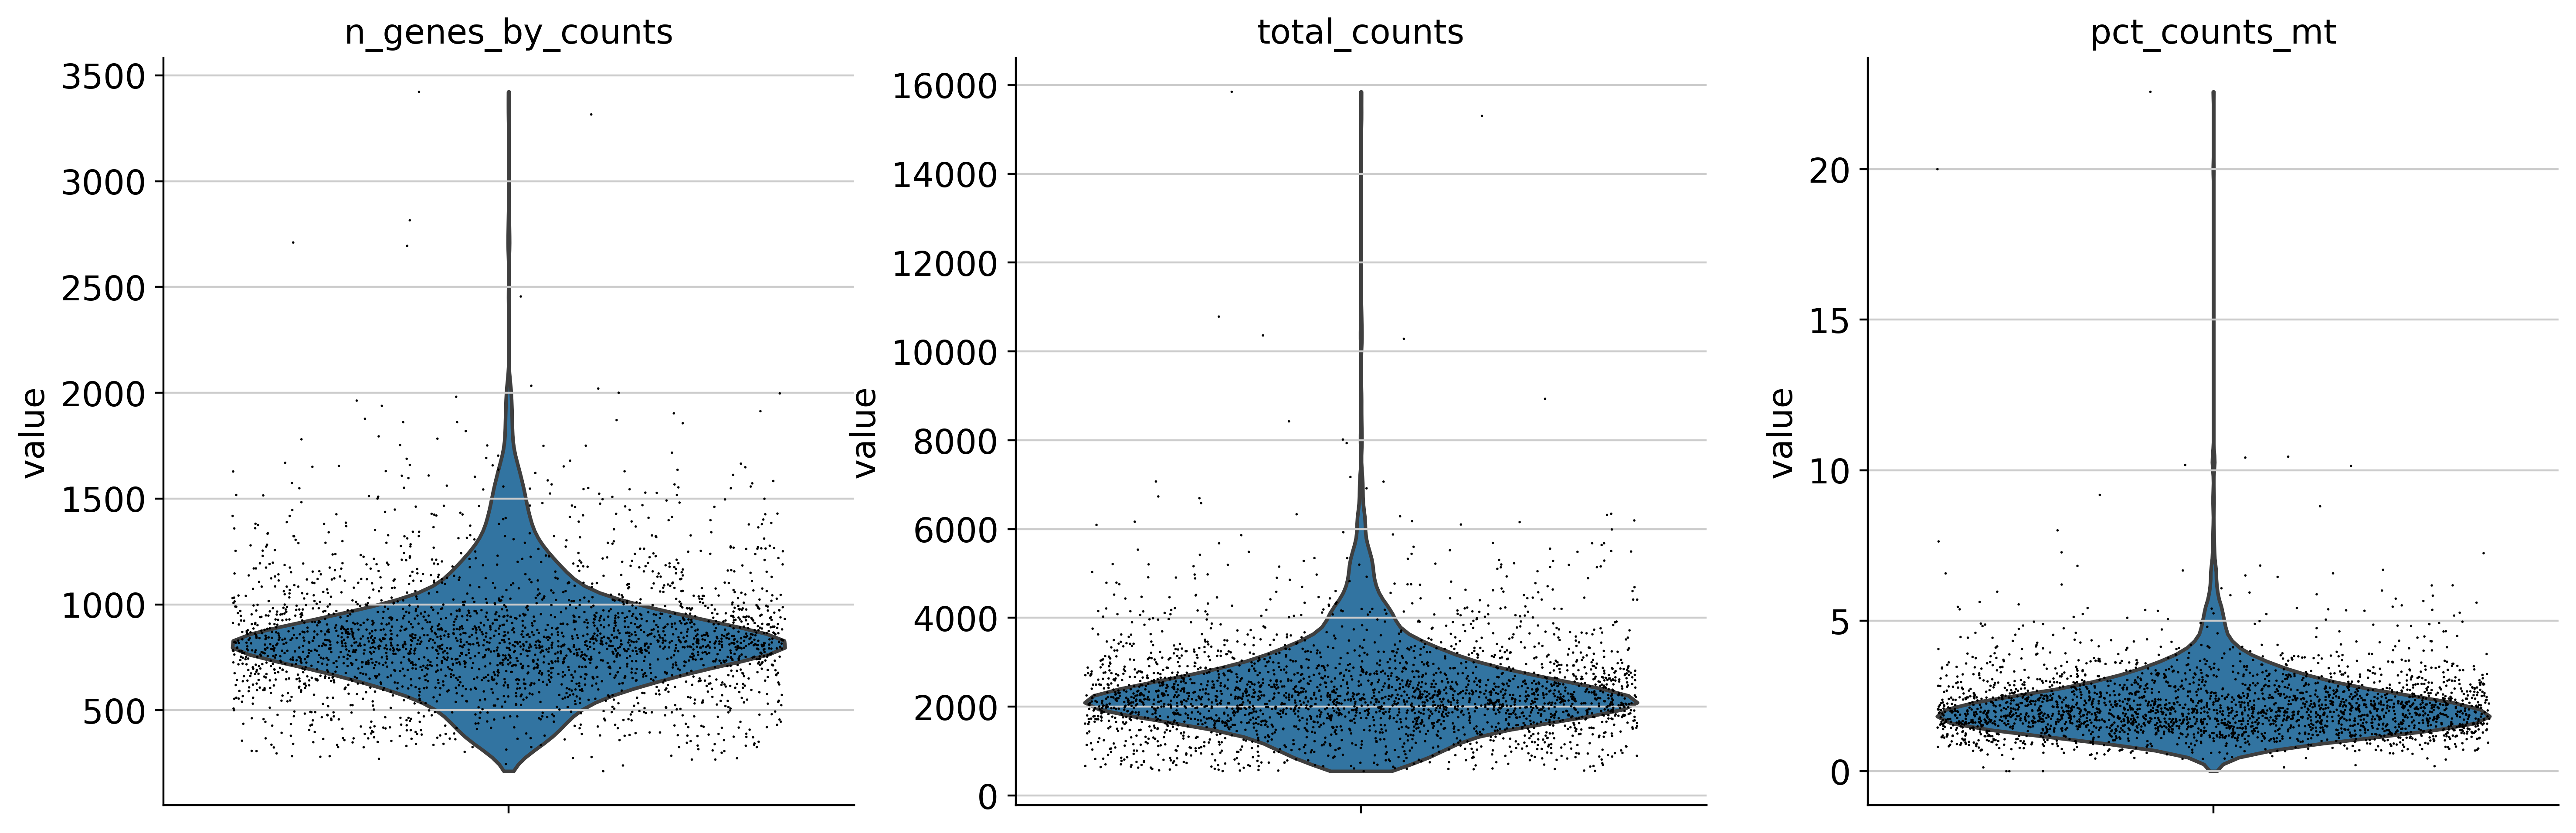

In [8]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

### Scatter Plots

We can also look at plots of the number of genes per cell versus the number of counts per cell colored by mitochondrial fraction information. By looking at our QC metrics jointly we can get a better idea of what's going on in our data. For instance, a group of cells with many counts but few genes could initially be characterized as "dying" outliers. However, if they don't seem to show a high fraction of mitochondrial counts then they might not actually be "dying" and could be worth keeping in our data. Along similar lines, cells with lower counts and genes that tend to have a higher fraction of mitochondrial counts are likely under stress or are dying and should be removed from the dataset (when apoptotic cells are sequenced, there is less mRNA to be captured in the nucleus and therefore fewer counts overall and thus a higher fraction of mitochondrial counts). Cells with high mitochondrial activity with higher counts and genes per cell could indicate biologically relevant mitochondrial activity.

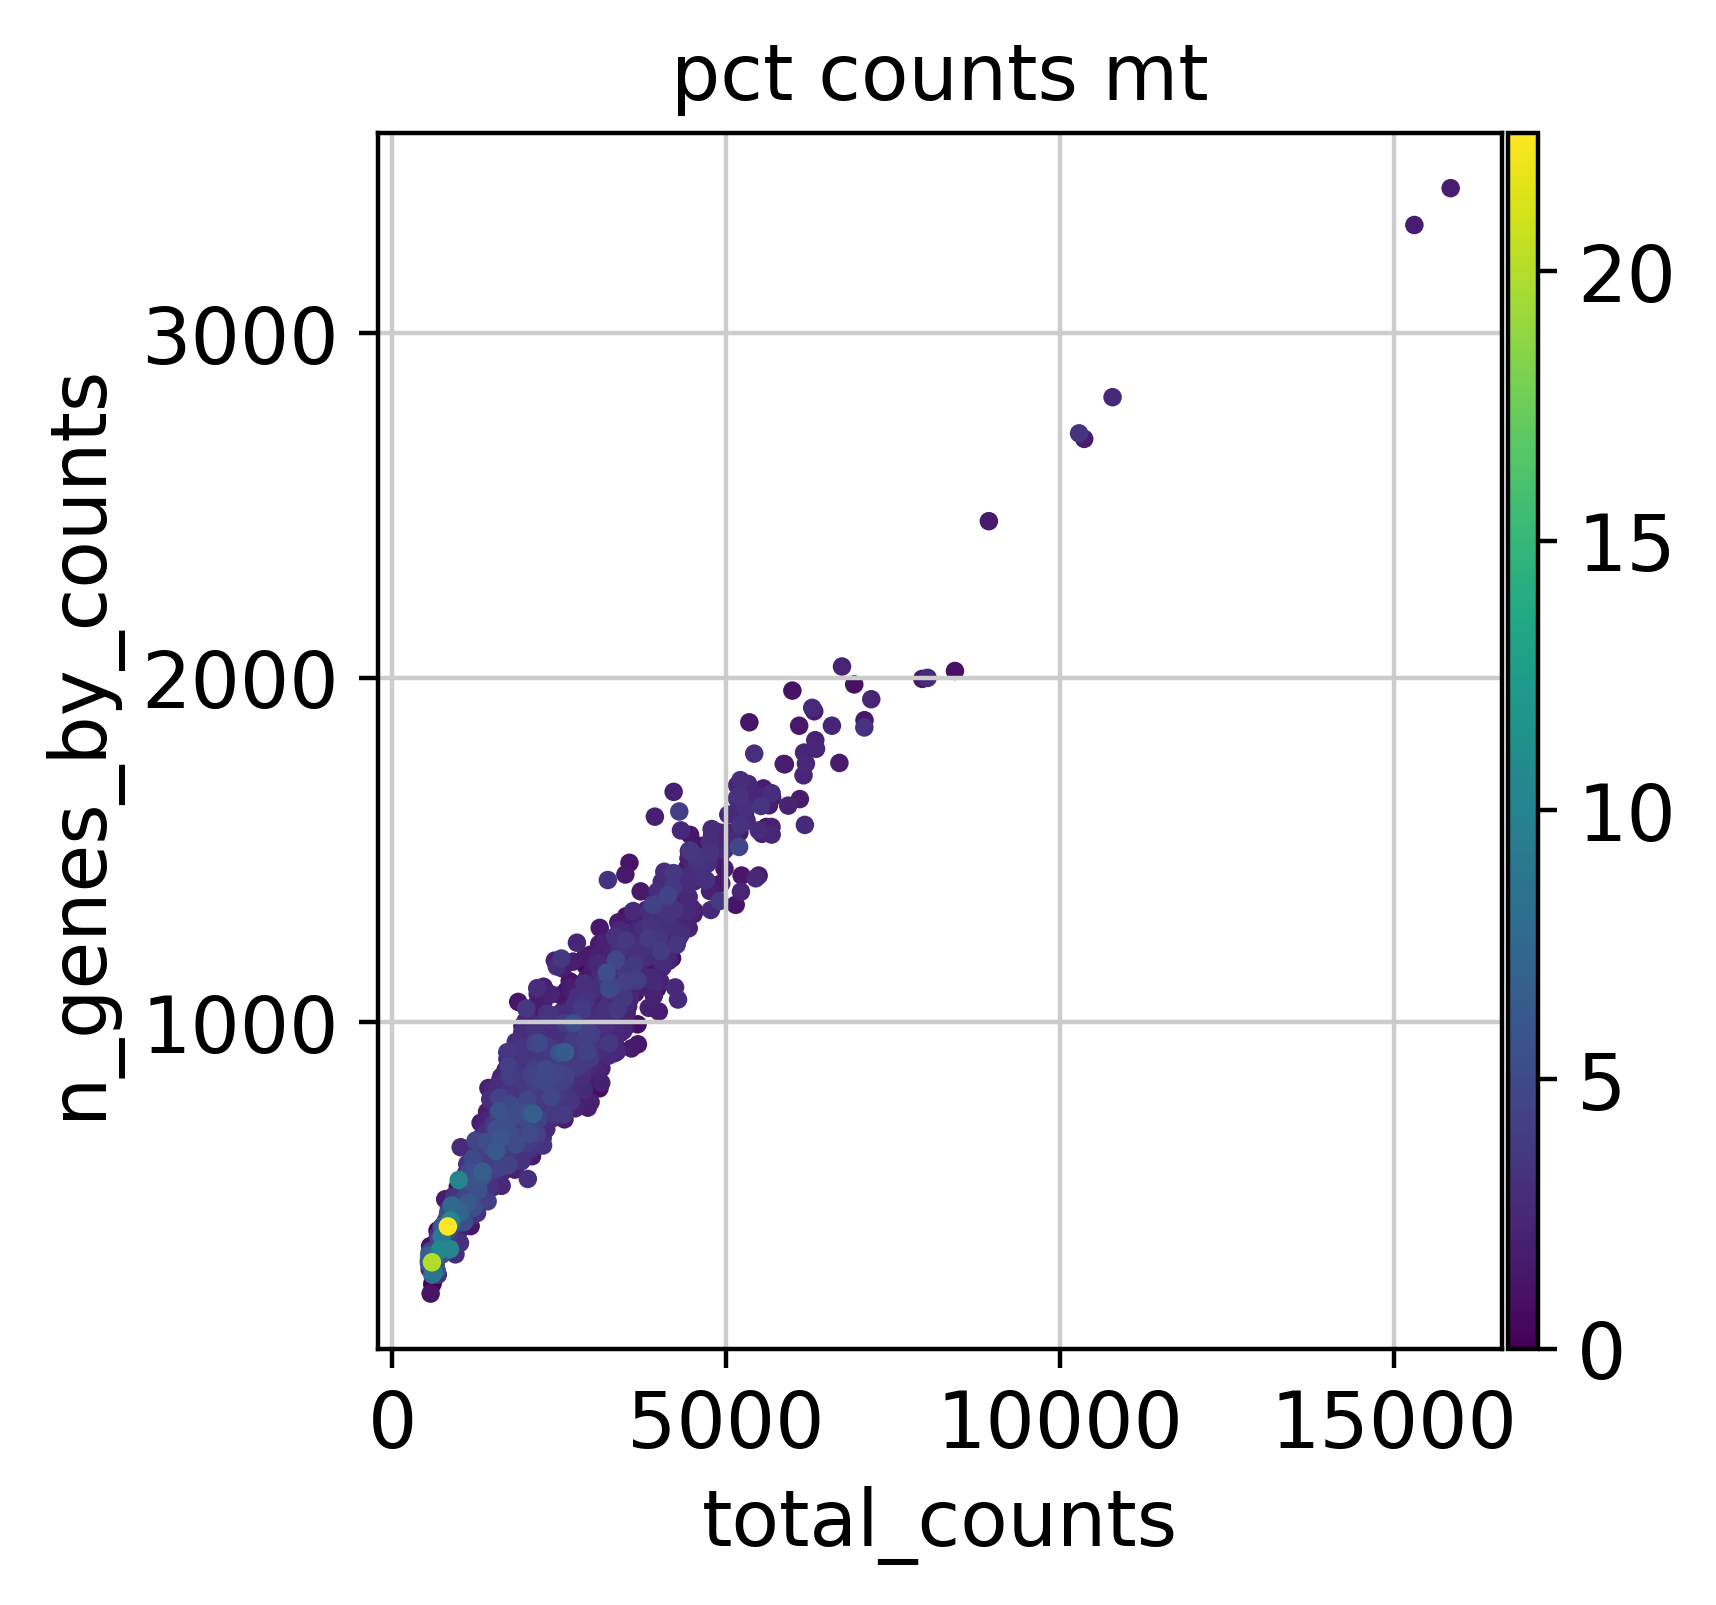

In [9]:
sc.pl.scatter(adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_mt') 

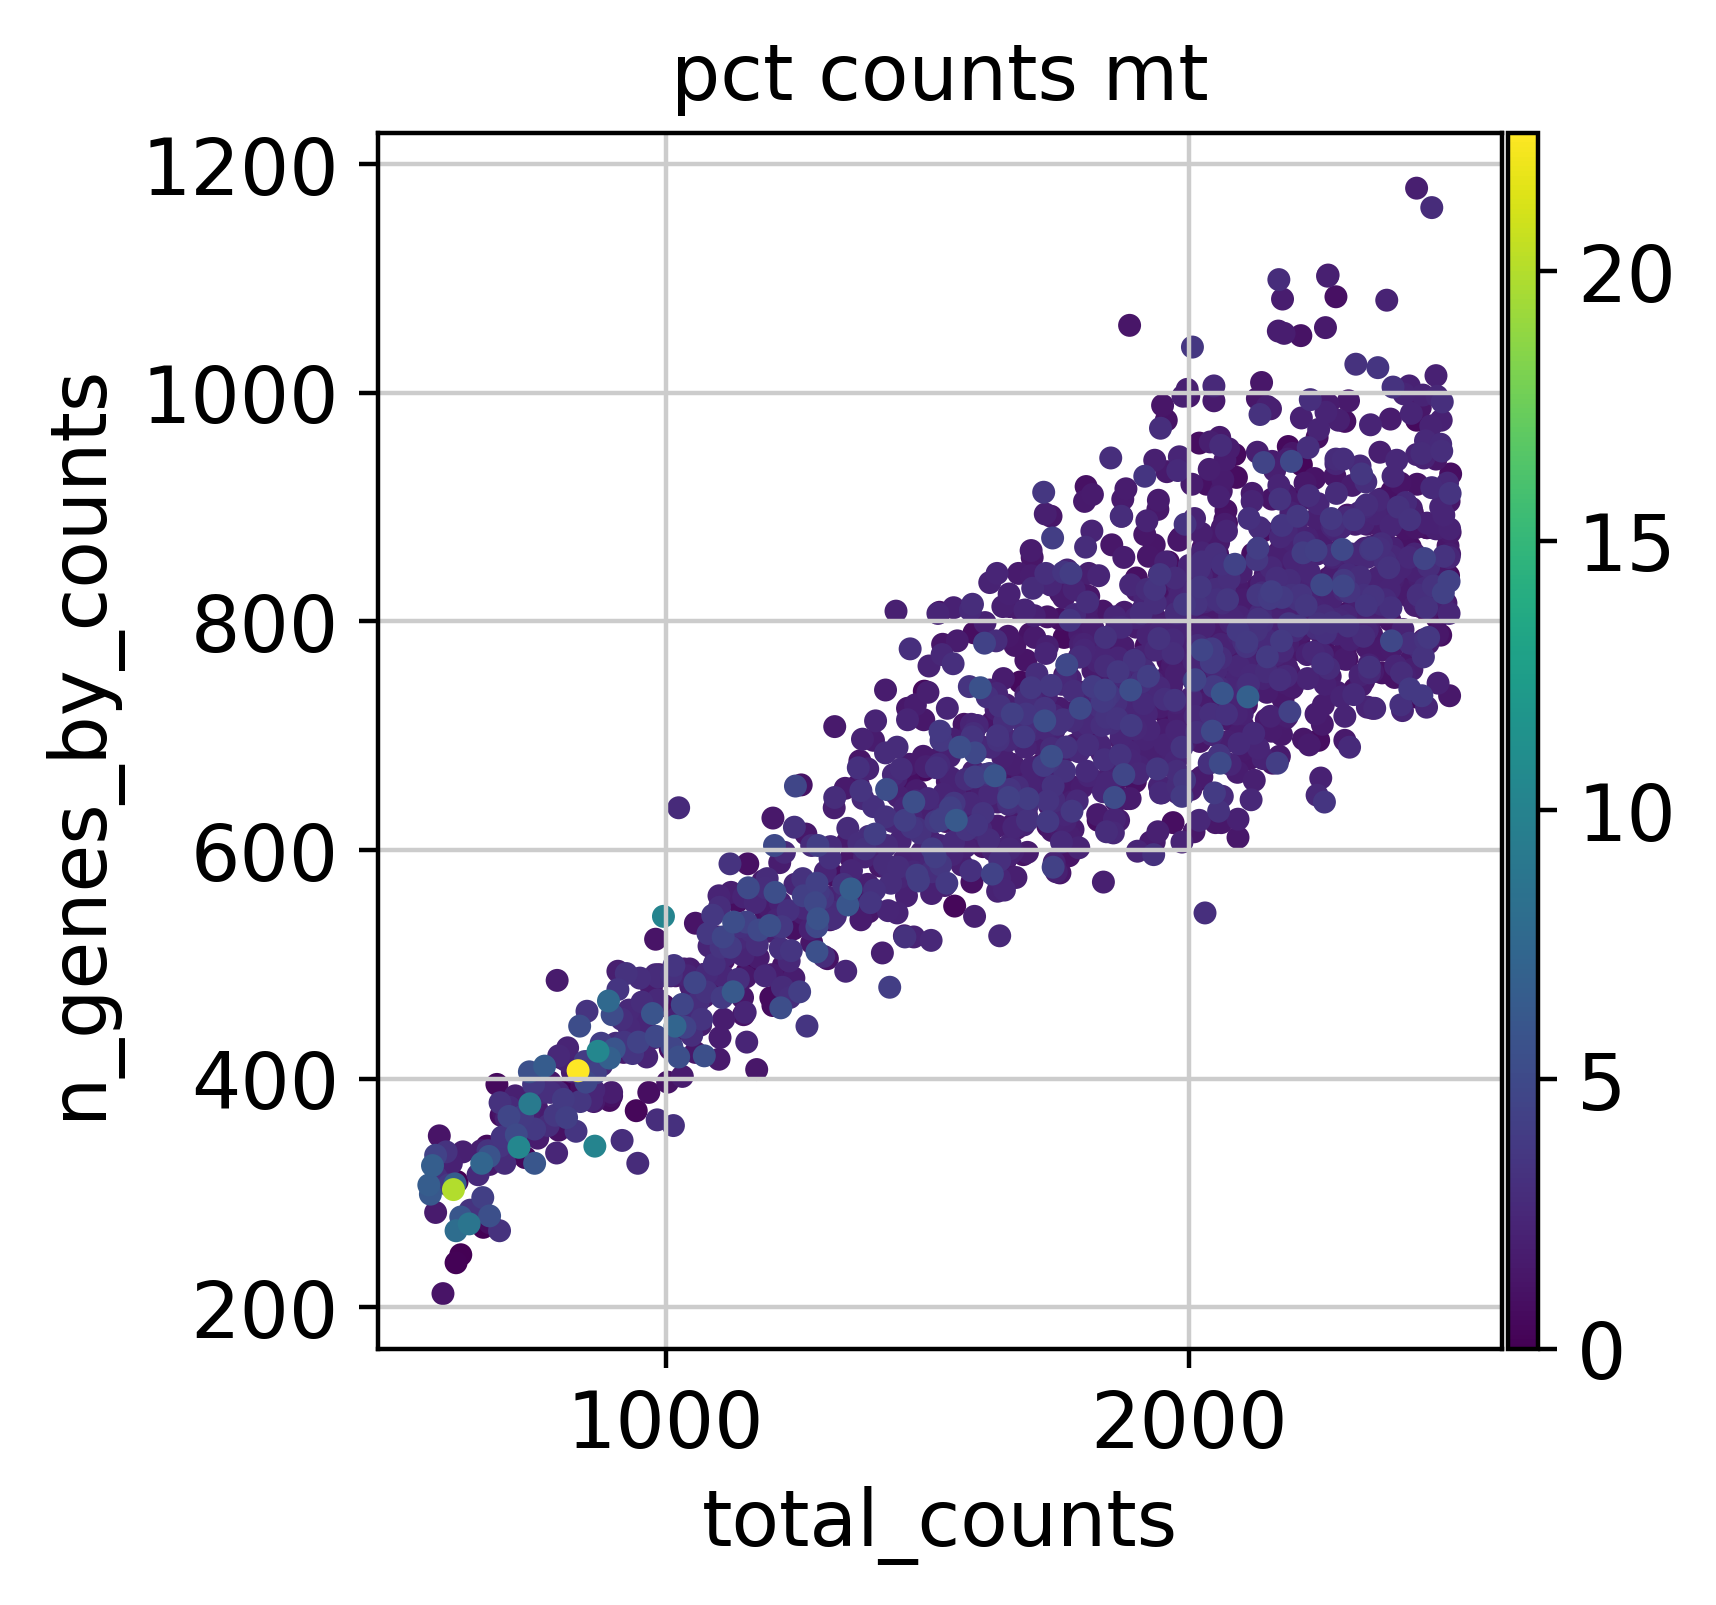

In [10]:
# this is the same plot as above, but 'zoomed' in on cells with less than 2500 counts
sc.pl.scatter(adata[adata.obs['total_counts']<2500], 'total_counts', 'n_genes_by_counts', color='pct_counts_mt') 

### Histograms

Histograms are another helpful way to assess the quality of your data. We can look for small peaks of groups of cells on the lower and upper end of counts and compare them to the overall distribution of counts. Often these small peaks are uninformative, with peaks on the lower end of counts representing potential cellular debris found in droplets and peaks on the upper end of counts representing doublets.

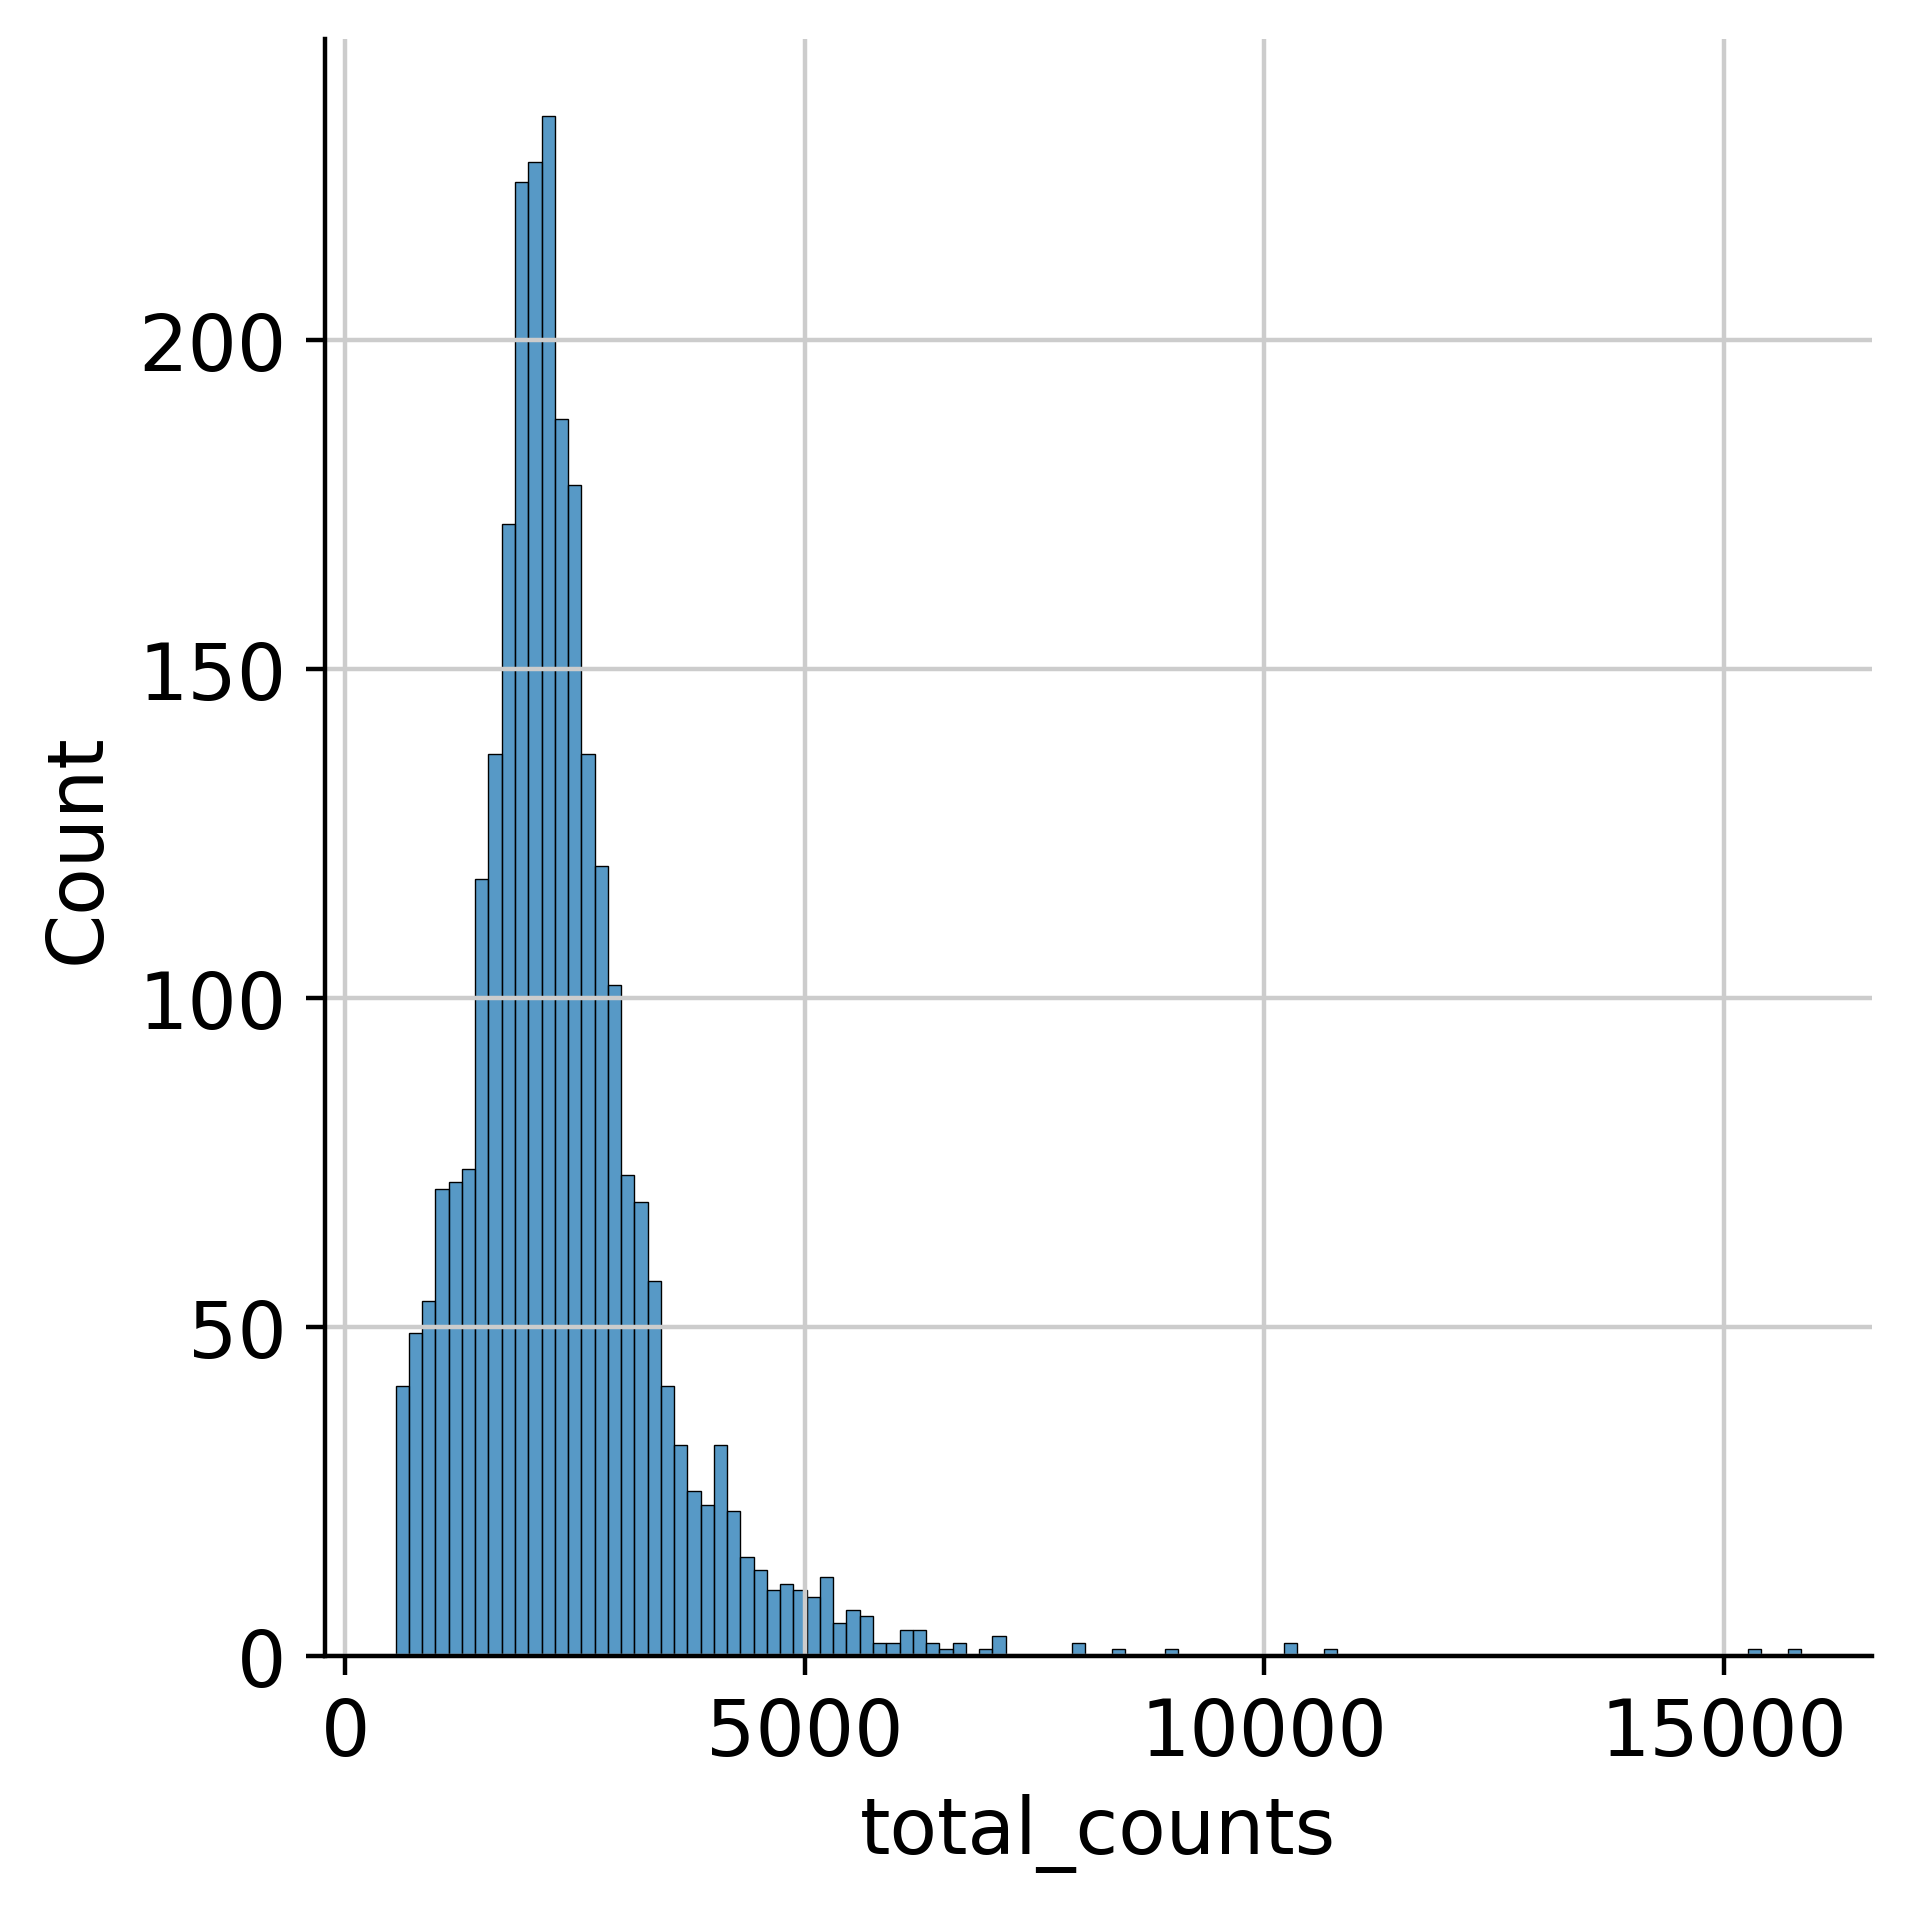

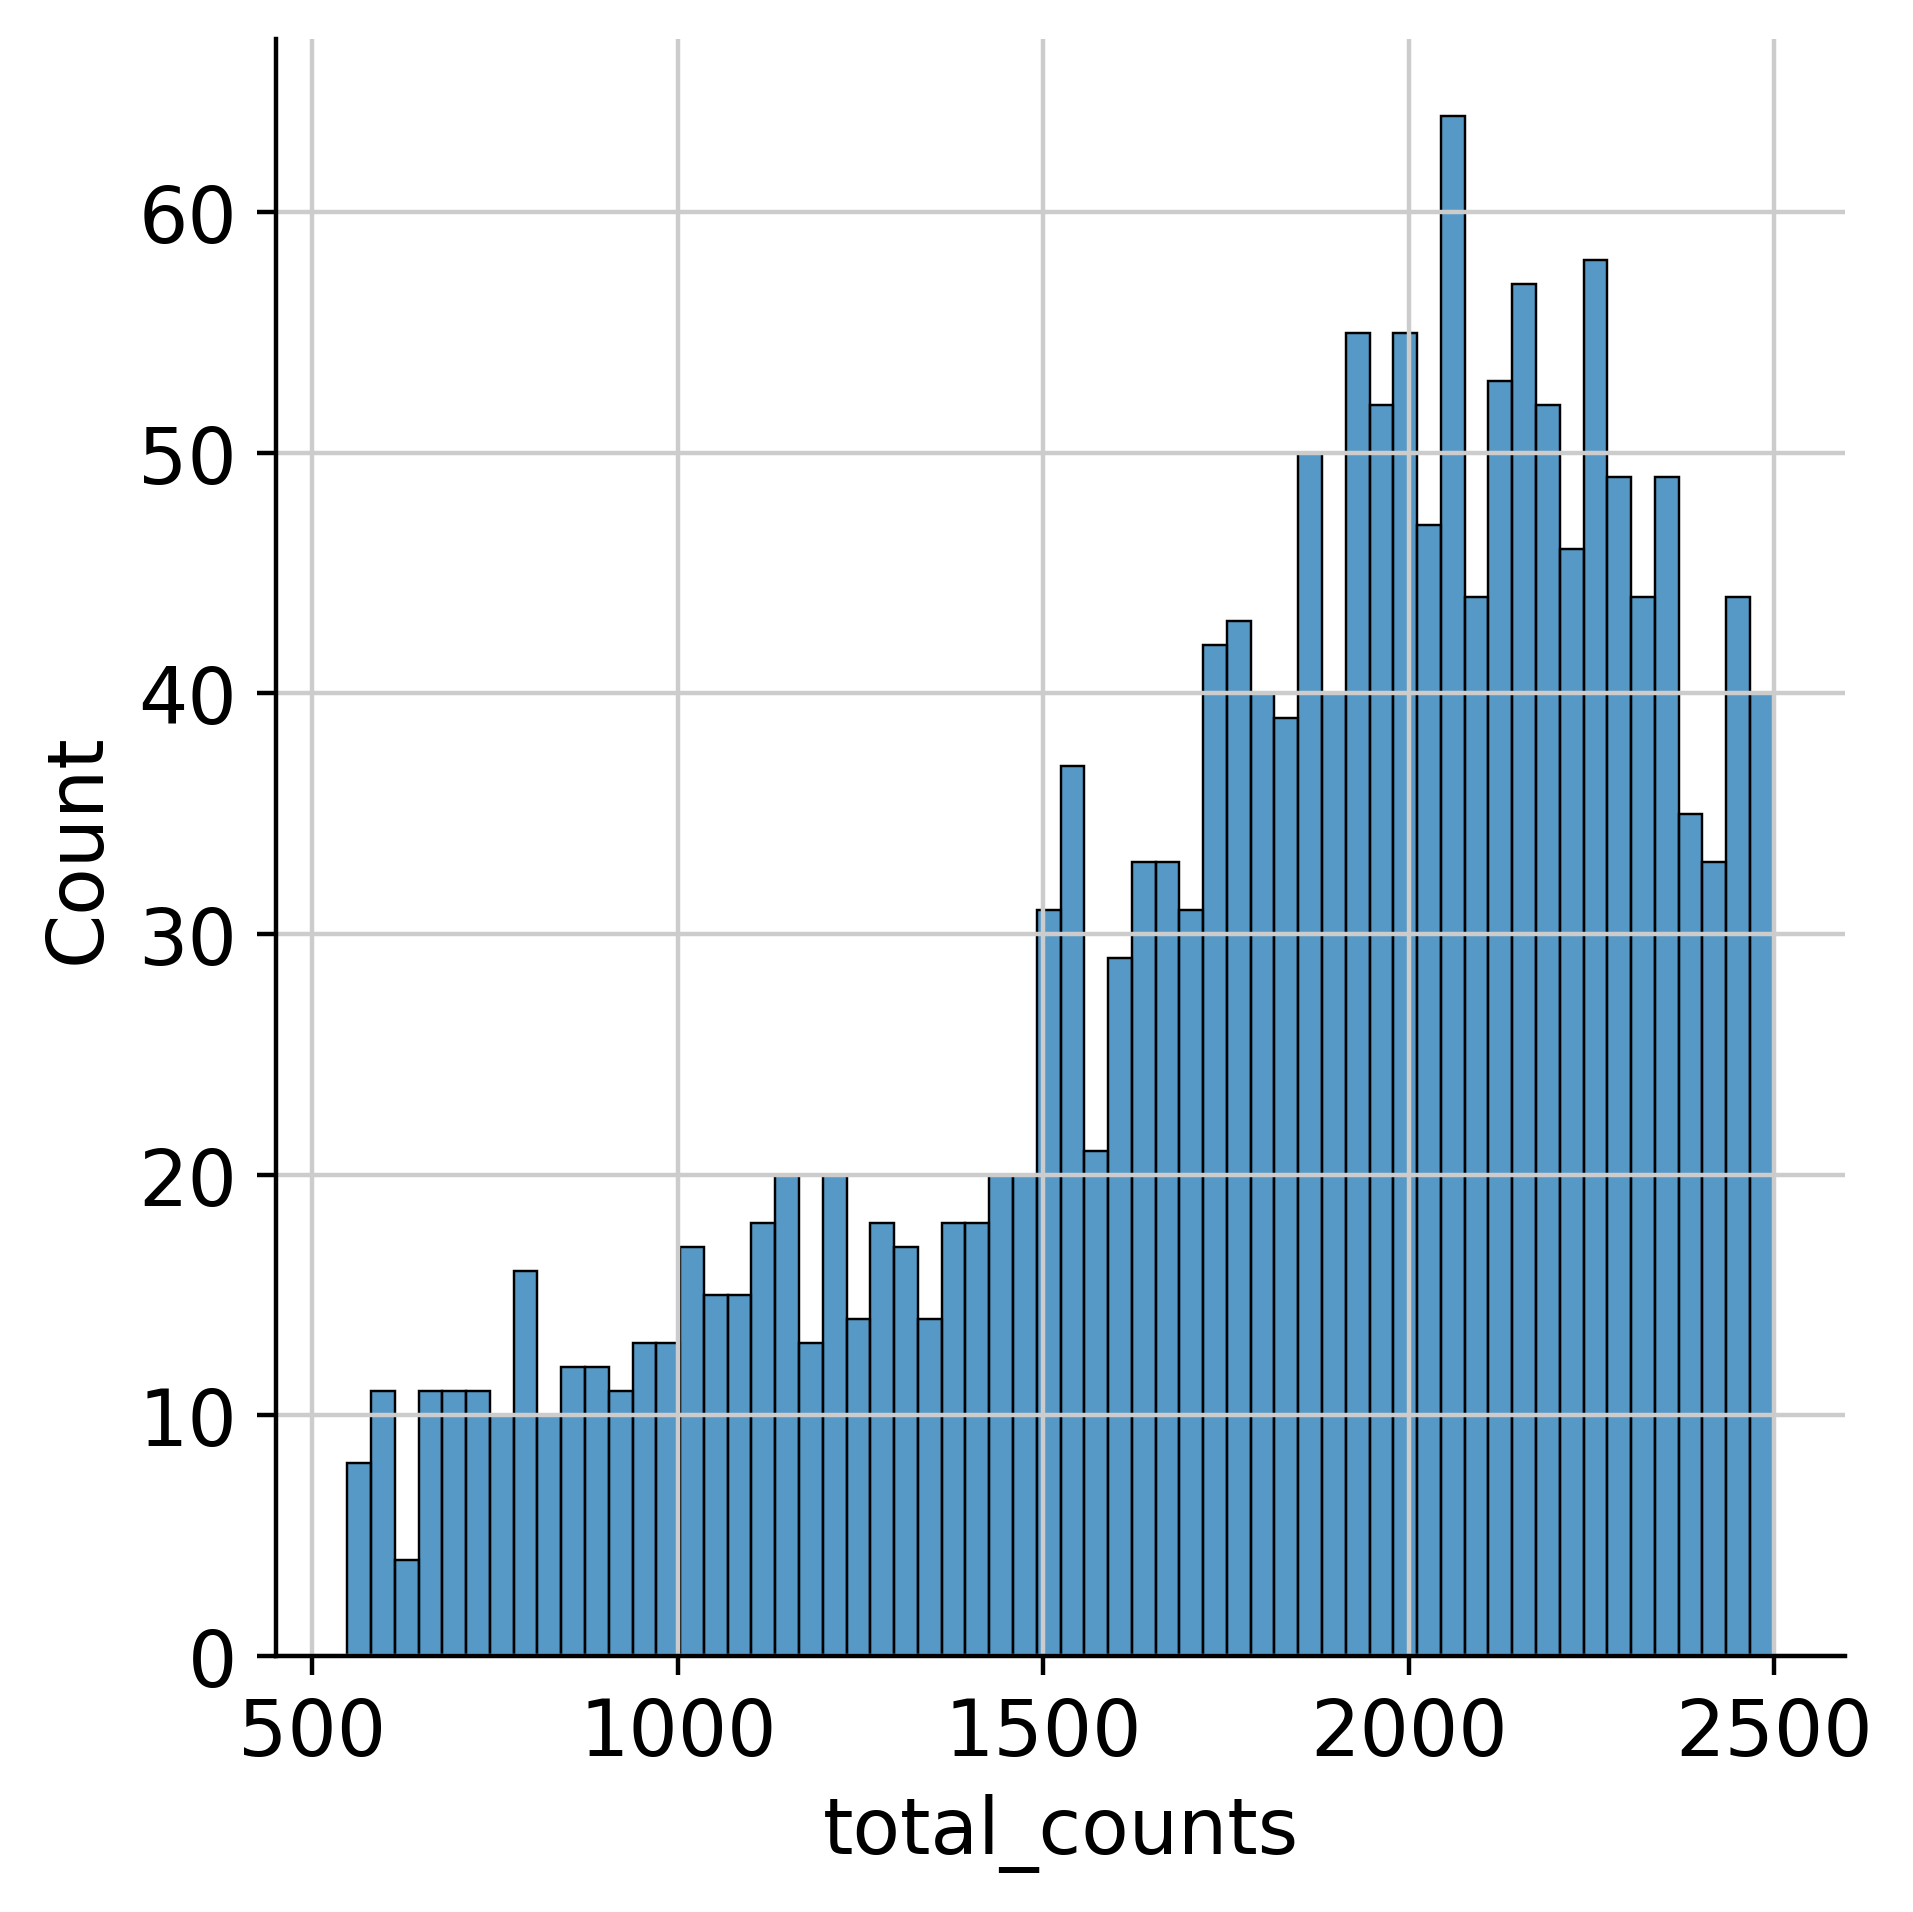

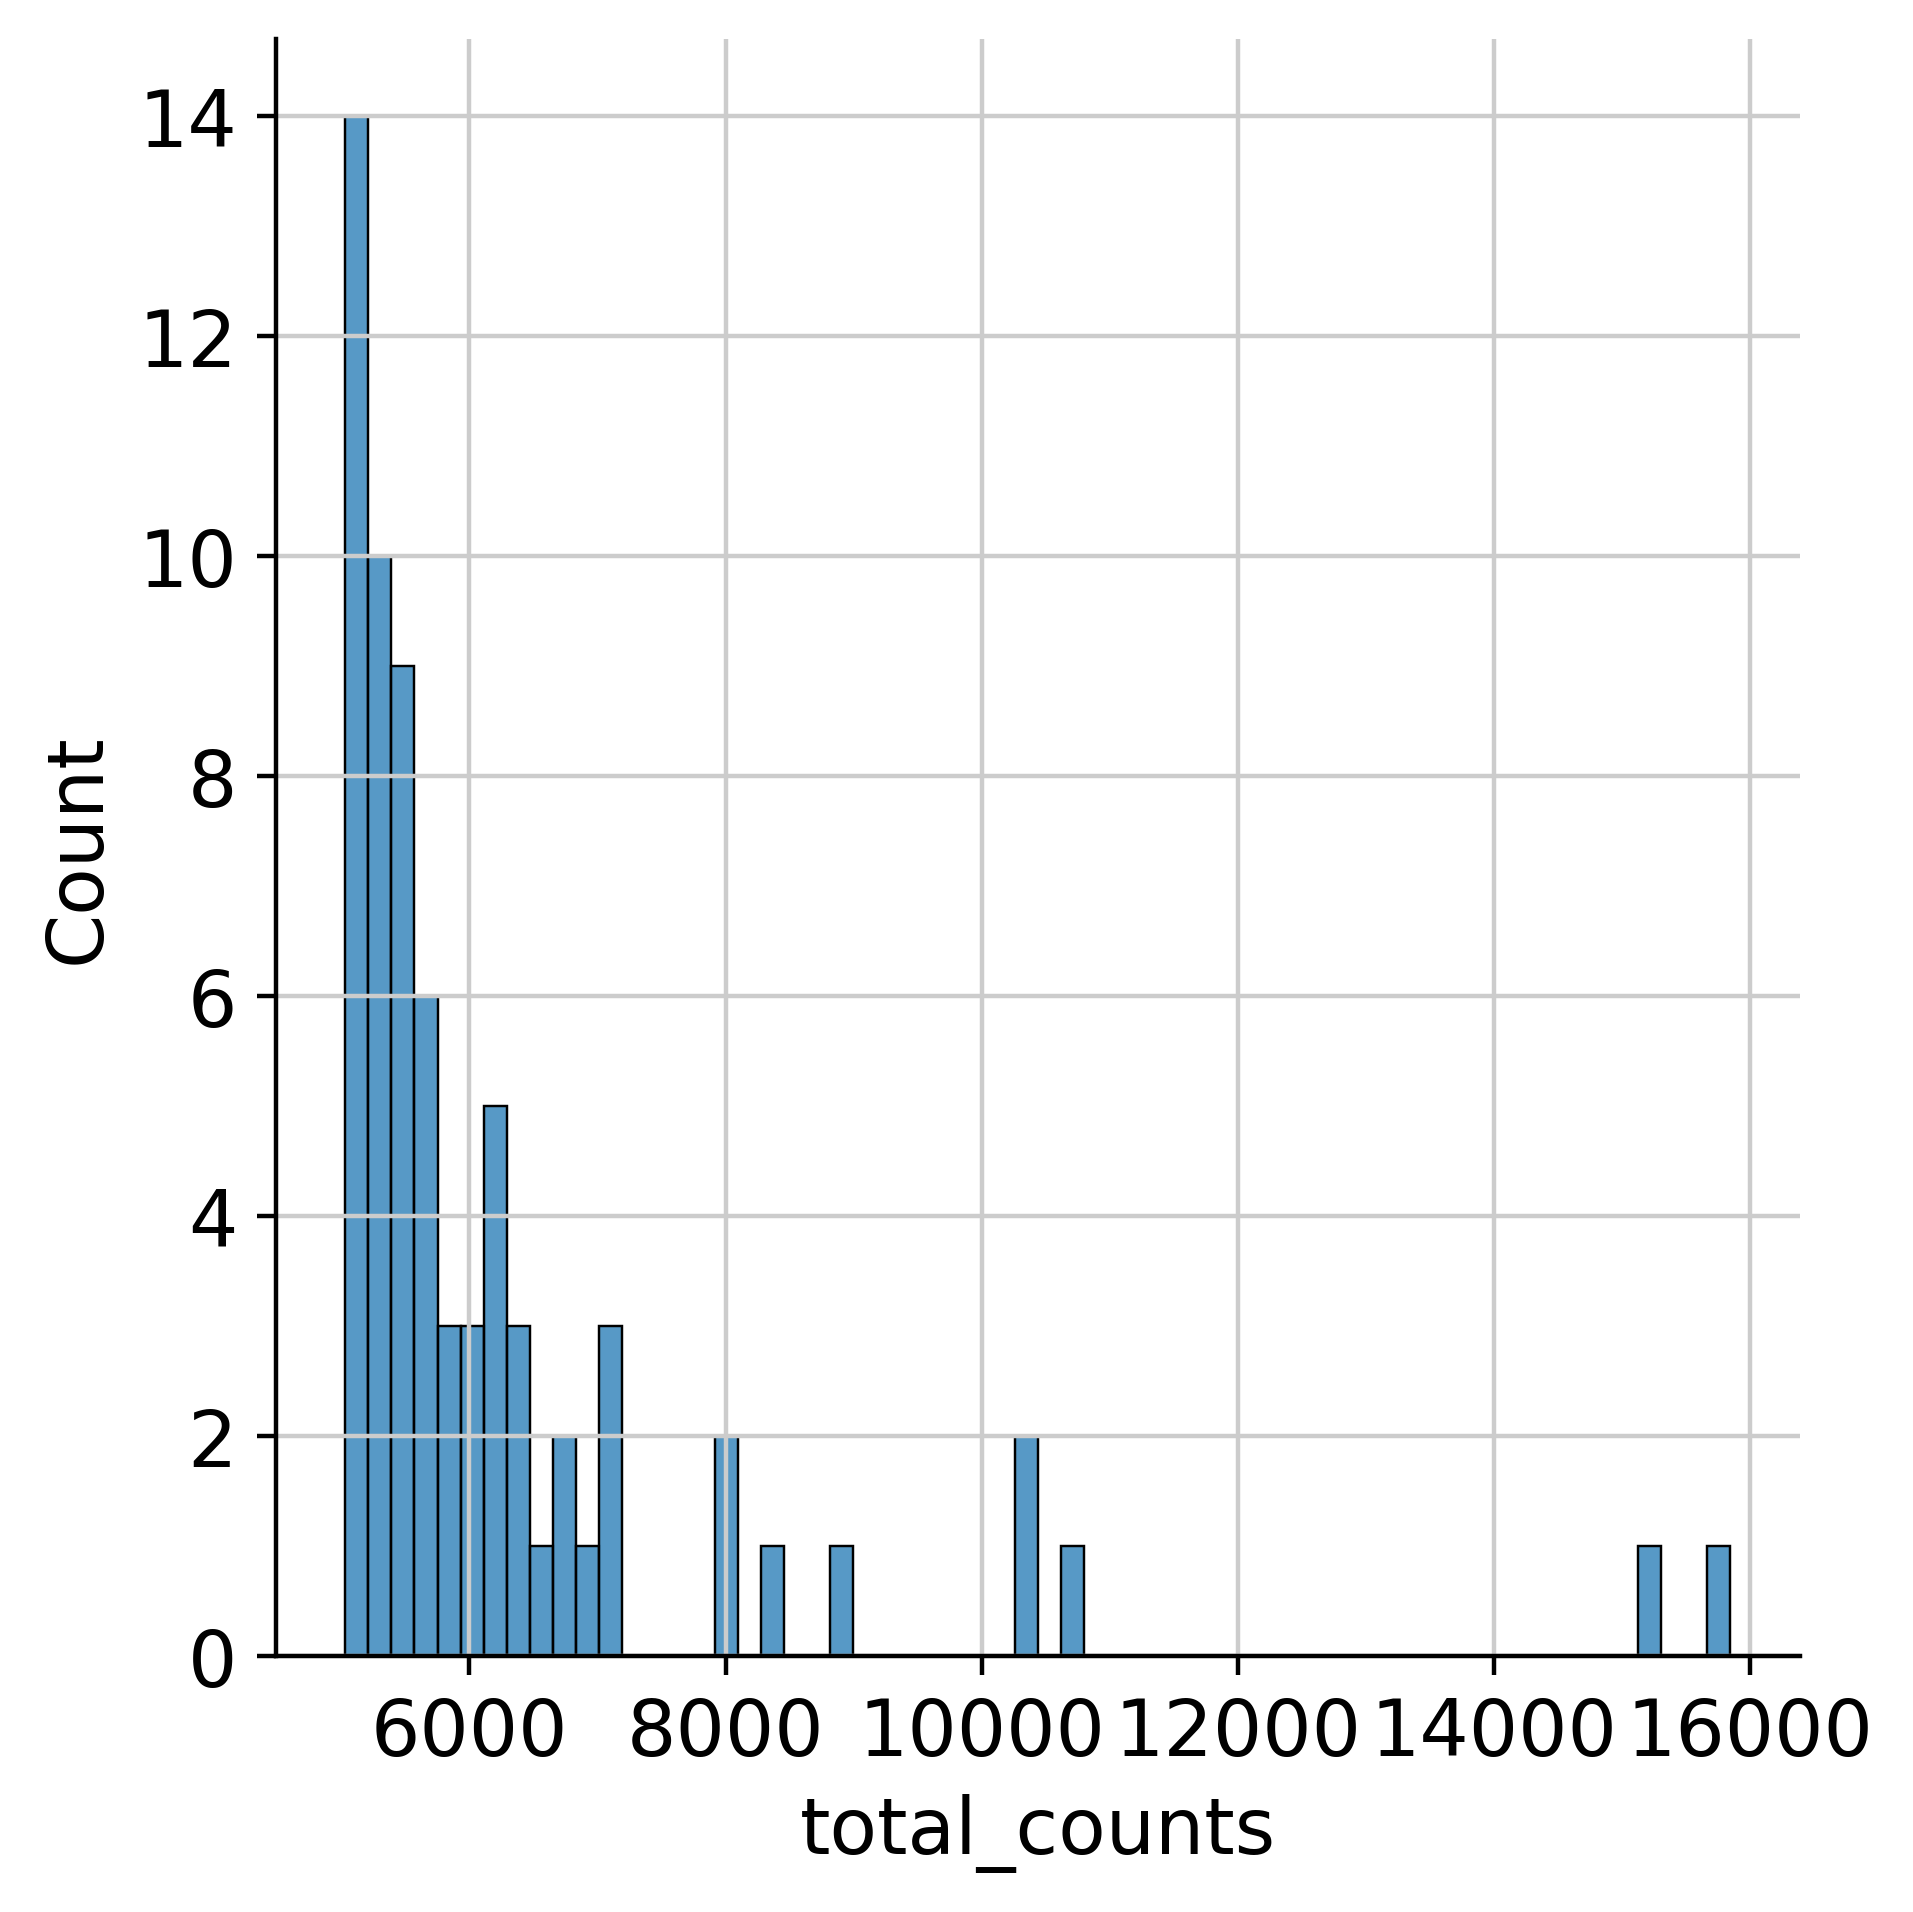

In [11]:
# Thresholding decision: counts
p1 = sb.displot(adata.obs['total_counts'], kde=False)
plt.show()

# same plot as p1 above, but only looking at cells with less than 2500 counts
p2 = sb.displot(adata.obs['total_counts'][adata.obs['total_counts']<2500], kde=False, bins=60)
plt.show()

# same plot as p1, but only looking at cells with more than 5000 counts
p3 = sb.displot(adata.obs['total_counts'][adata.obs['total_counts']>5000], kde=False, bins=60)
plt.show()

We can also look at gene counts, which combined with the joint plot of genes vs counts above can help us determine our filtering cutouffs.

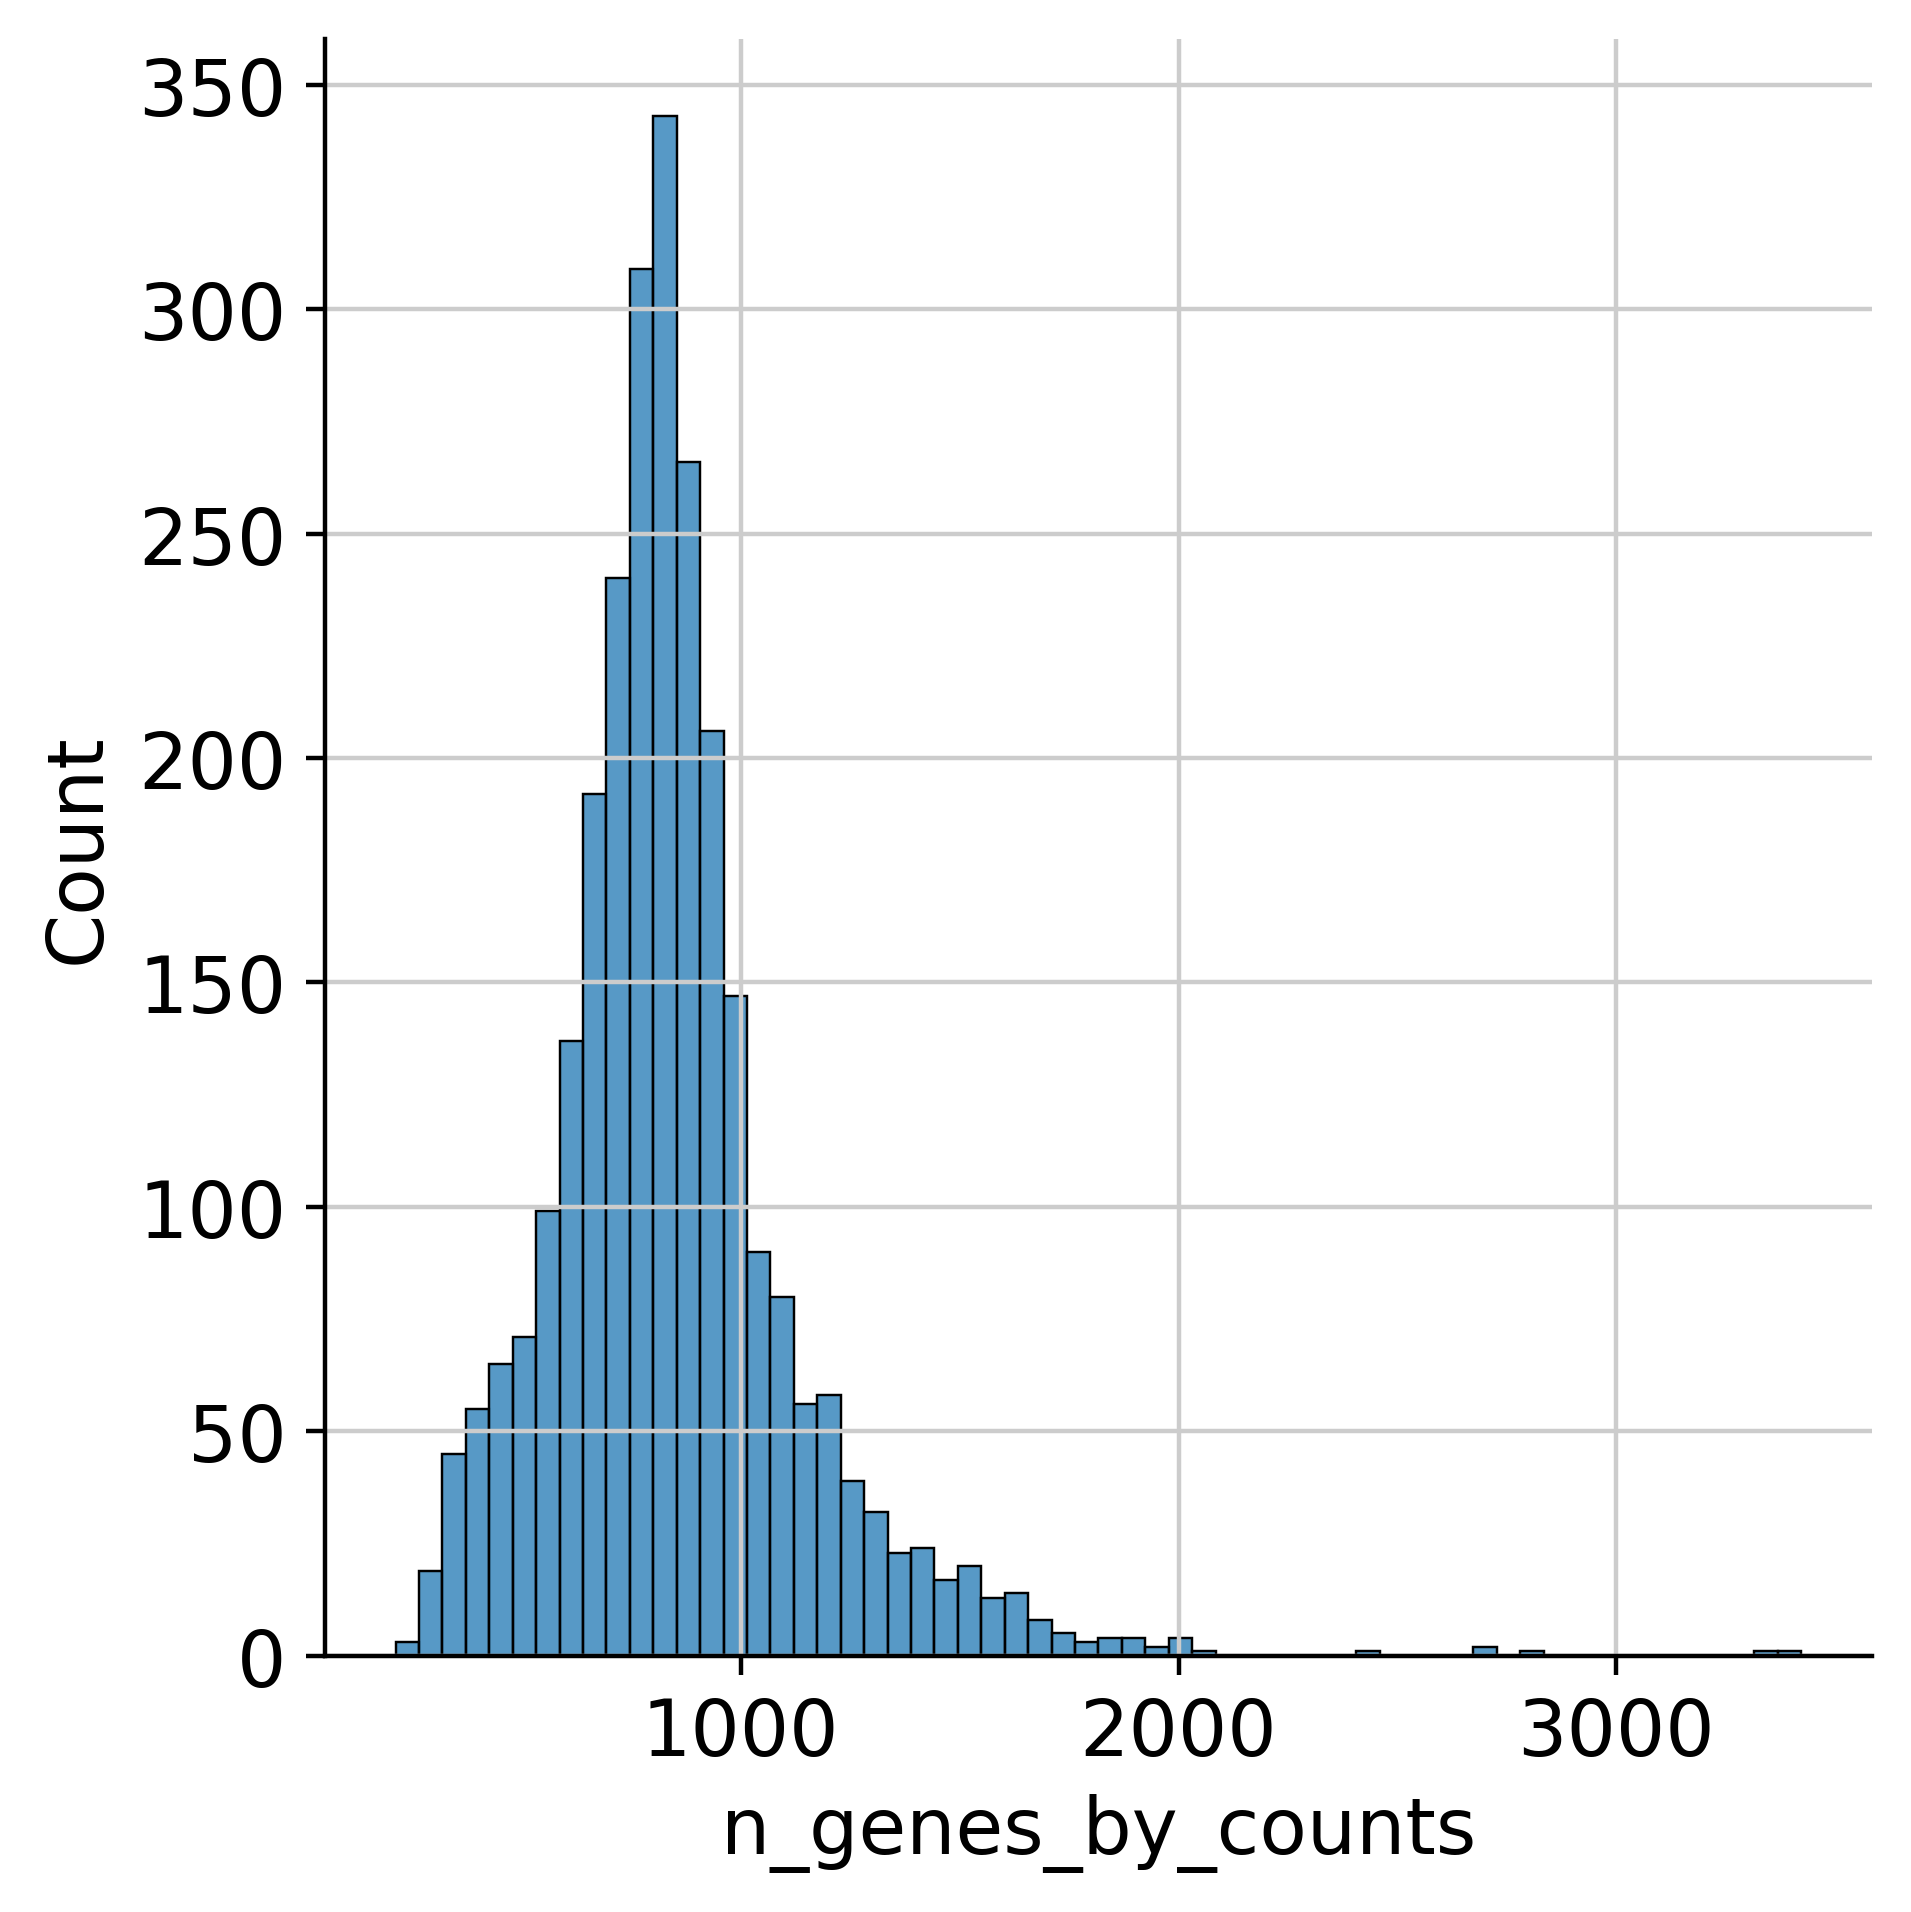

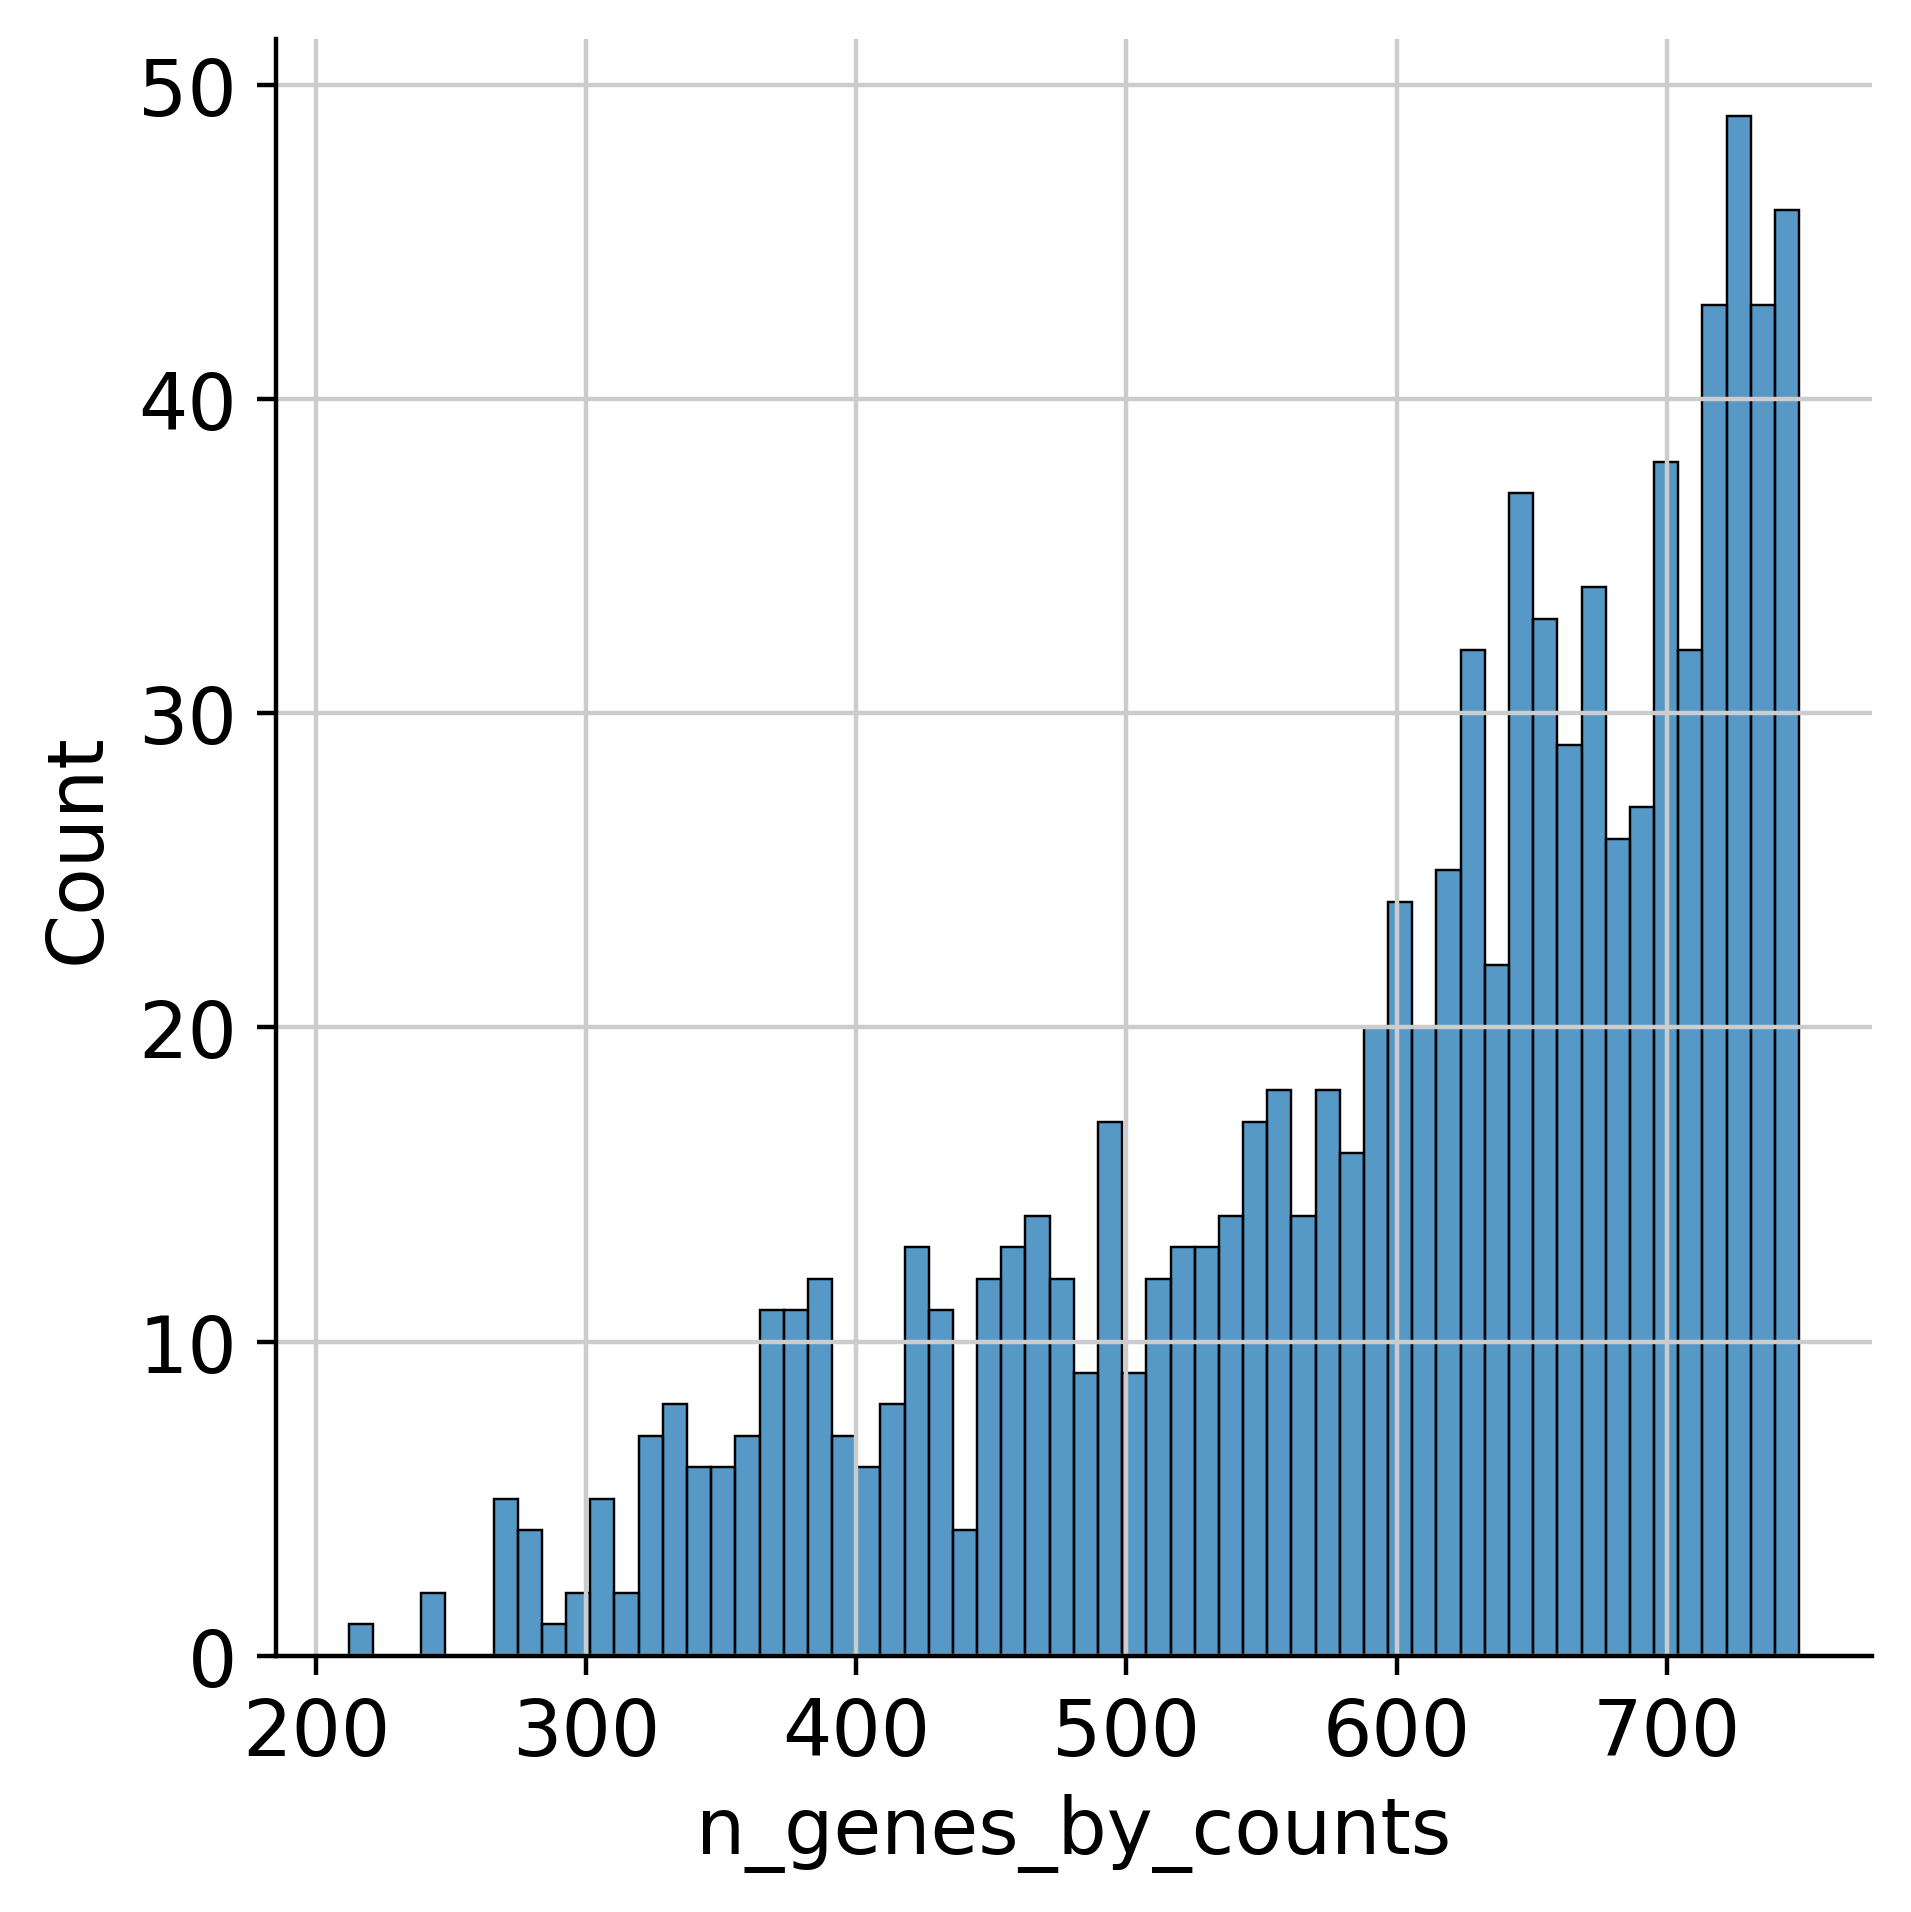

In [12]:
# Thresholding decision: genes
p4 = sb.displot(adata.obs['n_genes_by_counts'], kde=False, bins=60)
plt.show()

# same as p4 above, but only looking at cells with less than 750 genes
p5 = sb.displot(adata.obs['n_genes_by_counts'][adata.obs['n_genes_by_counts']<750], kde=False, bins=60)
plt.show()

## Filtering Cells

Looking at all of our QC plots above, we can start to get an idea of what are true and healthy cells we should keep in our dataset and what cells we should filter out. We can filter cells on as many or as few metrics as is appropriate for our dataset. Here, we filter cells based on a minimal counts threshold, maximum counts threshold, mitochondrial percentage, and minimal genes threshold. We also filter genes based on a minimal cell threshold.

In [13]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 1000)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 6000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['pct_counts_mt'] < 15]
print('Number of cells after mito filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 300)
print('Number of cells after min gene filter: {:d}'.format(adata.n_obs))

# Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

sc.pp.filter_genes(adata, min_cells = 1)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of cells: 2700
filtered out 153 cells that have less than 1000 counts
Number of cells after min count filter: 2547
filtered out 26 cells that have more than 6000 counts


Trying to set attribute `.obs` of view, copying.


Number of cells after max count filter: 2521
Number of cells after mito filter: 2521
Number of cells after min gene filter: 2521
Total number of genes: 32738
filtered out 16268 genes that are detected in less than 1 cells
Number of genes after cell filter: 16470


# 5 Normalization

In scRNA-seq analyses we can't just take the raw read counts to compare gene expression between cells because the raw read counts are confounded by technical and 'uninteresting' biological variations, primarily due to differences in sequencing depth (the number of reads obtained, also called *library size*; sequencing depth can vary by orders of magnitude across different cells in a scRNA-seq dataset), but also due to differences in cell lysis and reverse transcription efficiency. The goal of normalization is to remove the influence of these confounding factors while preserving true biological heterogeneity (i.e., adjust the dataset such that the variance of a gene is independent of gene abundance and sequencing depth of a cell).

So how do we normalize our dataset? The simplest and most commonly used group of normalization strategies is *scaling normalization*. Scanpy has a built in function to perform *library size normalization*, a type of scaling normalization. *Library size* is defined as the total sum of counts across all genes for each cell (i.e., the number of unique mRNA molecules detected in an individual cell). *Library size normalization* aligns the scales of gene expression across cells that have different numbers of UMIs per cell, such that we are comparing the ratios of genes detected within a cell as opposed to the absolute quantity of each RNA. Each count of each gene in each cell is divided by the total number of UMIs in that cell, and then gene expression is multipled in all cells by a constant, such as the median number of UMIs per cell in an experiment, or 1e6 for CPM (counts per million) normalization.

In [14]:
# First, before normalizing, keep a copy of the raw count data in a counts layer
# Always save a copy of the raw count data, as some downstream analysis methods require it!!
adata.layers["counts"] = adata.X.copy()

In [15]:
# total-count normalize (library-size correct) the data to 10,000 reads per cell
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


Once our scRNA-seq data is normalized via *library size normalization*, we log-transform the result in order to achieve *linearity* (i.e., normalize the data distributions, which can help us obtain further insights into our data that may not be obvious at first). The log-transformation is useful as differences in the log-values represent log-fold changes in gene expression, which is used by some downstream procedures including clustering and dimensionality reduction.

In [16]:
# logarithmize the data
sc.pp.log1p(adata)

In [17]:
# Store the full data set in 'raw' as log-normalized data for statistical testing
# Downstream methods to visualize gene expression and compute marker genes for clusters will use the log-normalized data
adata.raw = adata

There are several other normalizaiton methods that people use when processing their scRNA-seq data, such as deconvolution methods and normalization by spike-ins. Which normalization method is "best" depends on your specific dataset and questions, but generally *library size normalization* is usually sufficient for exploratory scRNA-seq data analyses. For a deeper dive into normalization, we highly recommend reading the [*Normalization* chapter](https://bioconductor.org/books/release/OSCA/normalization.html) in Bioconductor's [*Orchestrating Single-Cell Analysis with Bioconductor*](https://bioconductor.org/books/release/OSCA/) (which is a fantastic resource overall for understanding the concepts behind scRNA-seq analysis, and is great if you are working in R!).

# 6 Highly Variable Genes

We extract highly variable genes (HVGs) to reduce the dimensionality of the dataset and include only the most informative genes. Genes that vary substantially across the dataset are informative of the underlying biological variation in the data. As we only want to capture biological variation in these genes, we select highly variable genes after normalization (and batch correction, if appropriate). HVGs are used for clustering, trajectory inference, and dimensionality reduction/visualization, while the full dataset is used for computing marker genes, differential testing, cell cycle scoring, and visualizing expression values on the data.

There is no good criteria to determine how many HVGs to use. Sometimes you need to experiment with different numbers and pick whatever number gives the most clear and interpretable result. Typically between 1000 and 5000 genes are selected.

In [18]:
# Extract highly variable genes to reduce dimensionality
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=2000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 2000


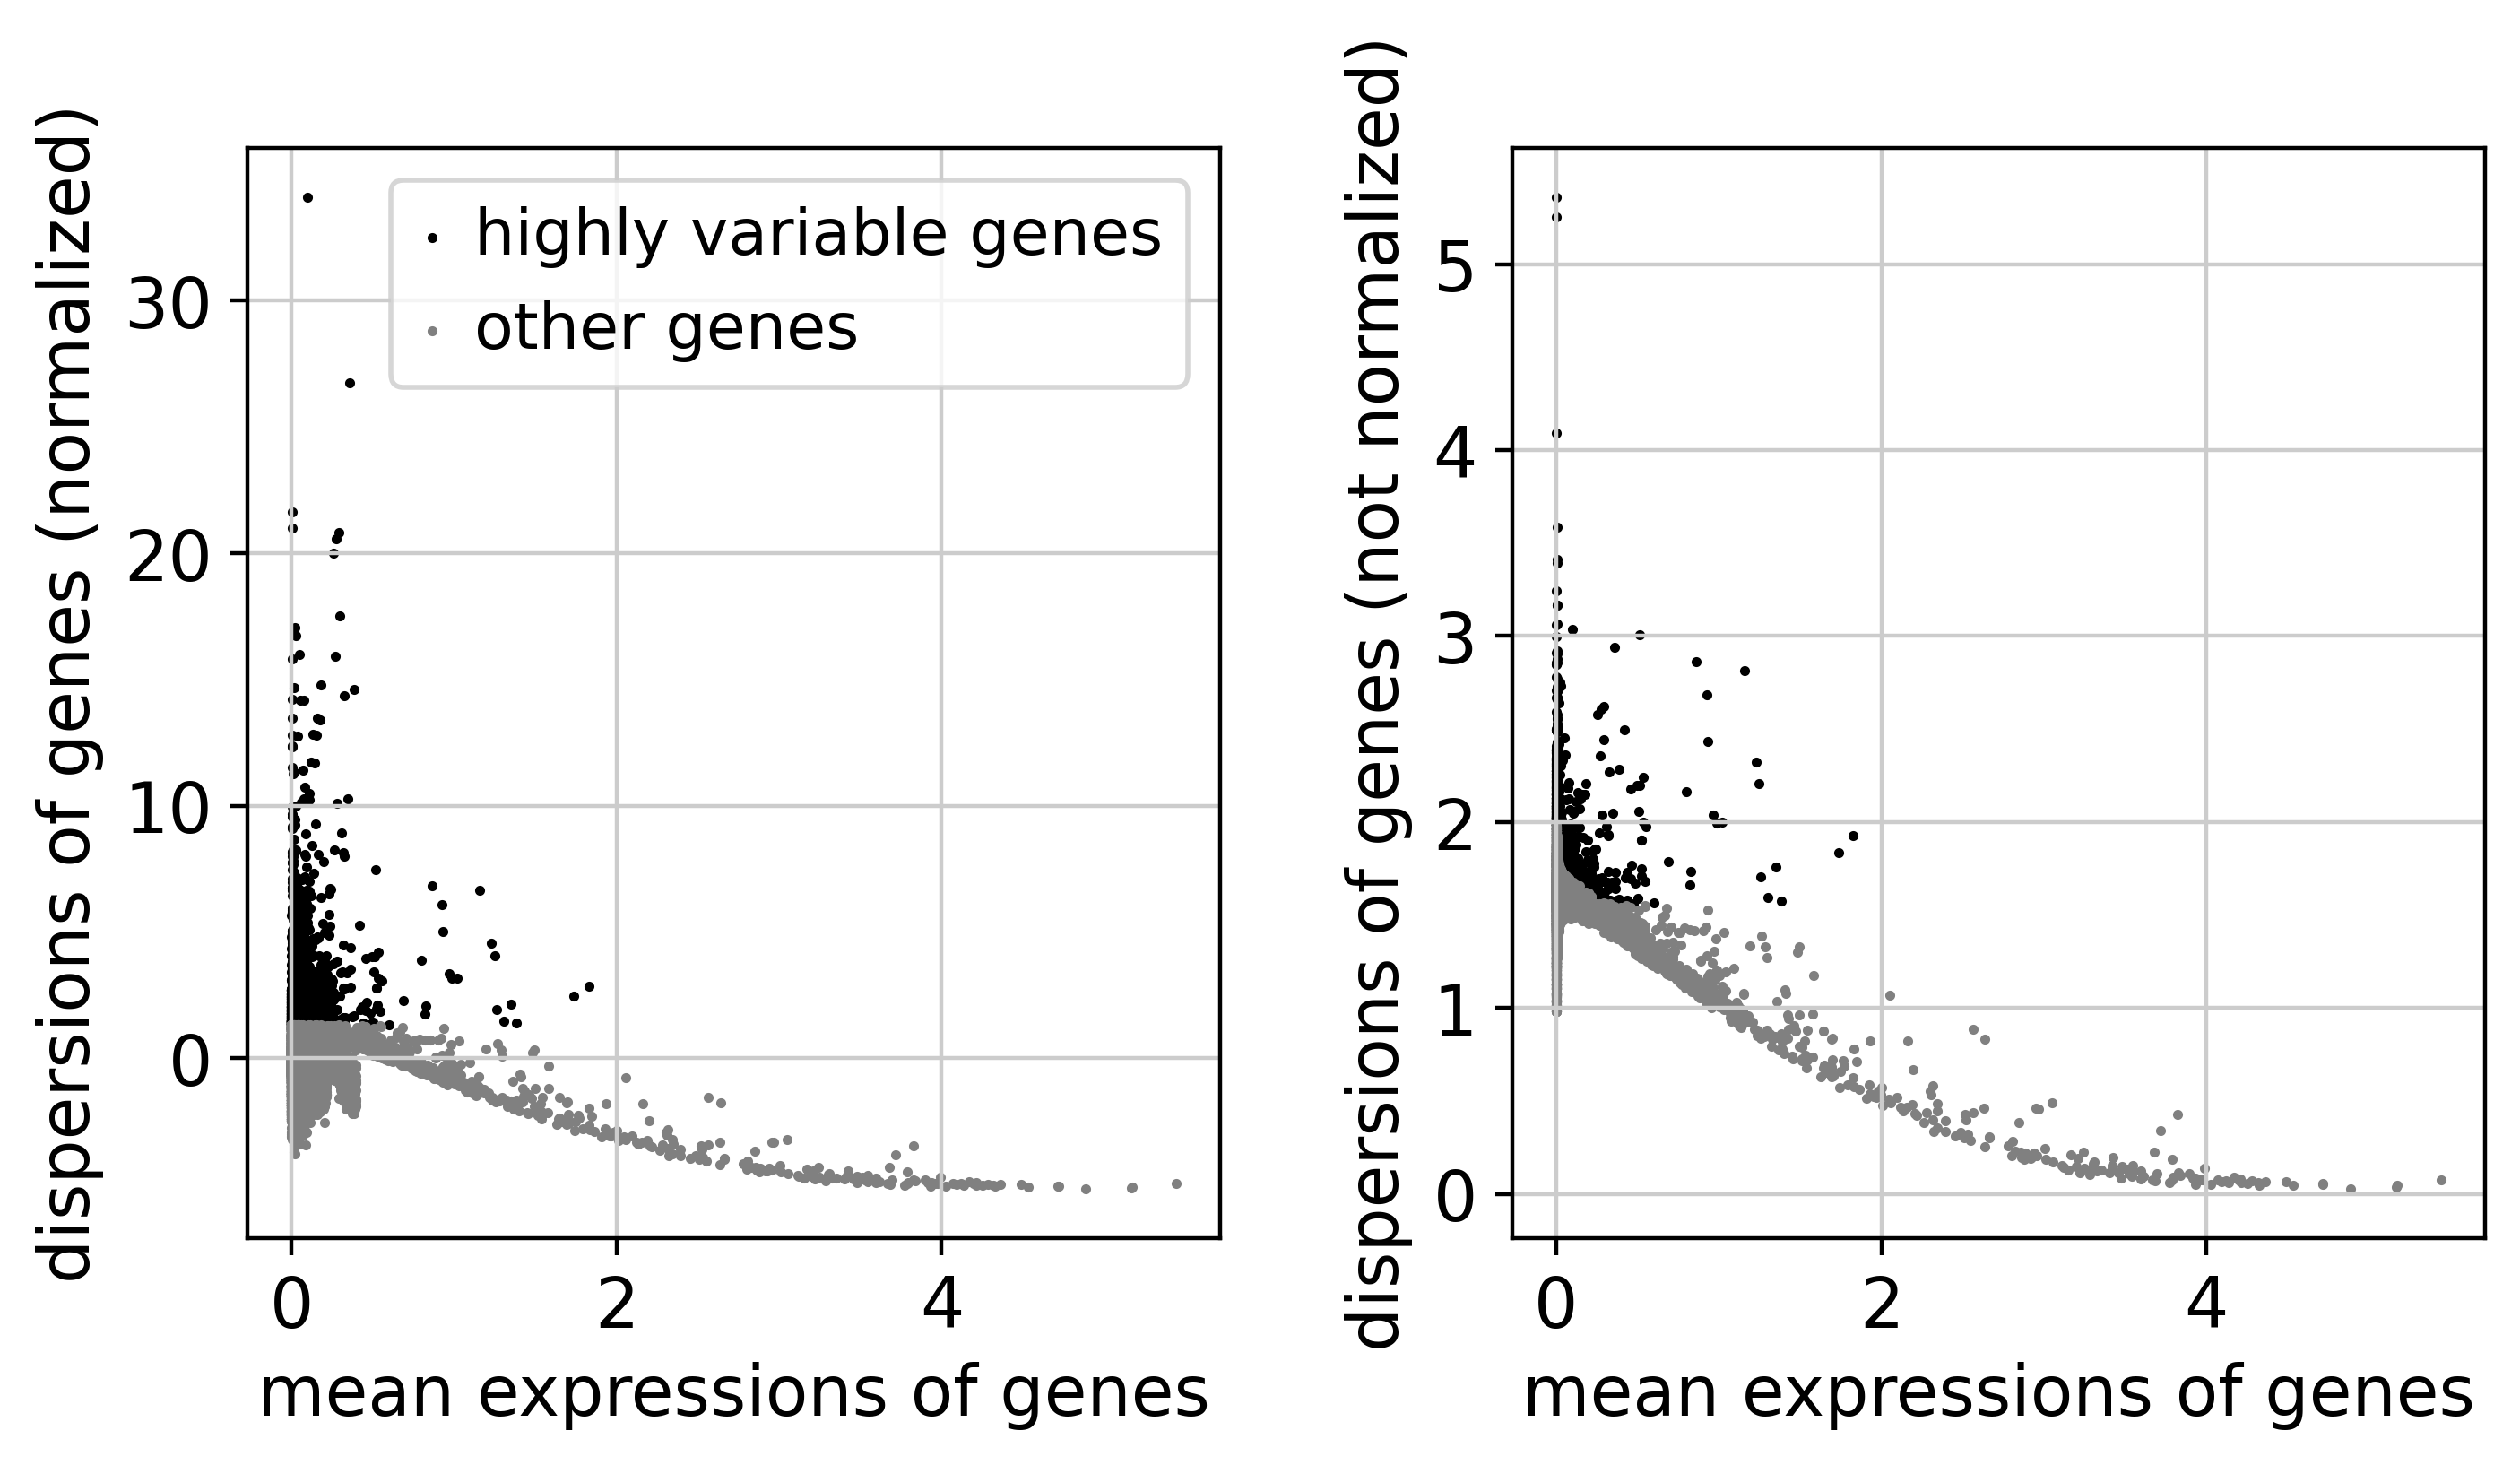

In [19]:
# Plot highly variable genes
# Plots show how data was normalized to select HVGs irrespective of the mean expression of the genes
sc.pl.highly_variable_genes(adata)

In [20]:
# Highly variable gene annotations are now stored in our adata object (adata.var['highly_variable'])
adata

AnnData object with n_obs × n_vars = 2521 × 16470
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

# 7 Visualization

Visualizing scRNA-seq data is the process of projecting a high-dimensional matrix of cells and genes into a few coordinates such that every cell is meaningfully represented in a two-dimensional graph. However, the visualization of scRNA-seq data is an active area of research and each method defines 'meaningful' in its own way. It is a good idea to look at several visualizations and decide which visualization best represents the aspect of the data that is being investigated. For instance, tsne plots provide great visualization when cells form distinct cell groups, while umap plots preserve trajectory-like structure better. Again, there are no "right" answers!

(Wait - aren't we supposed to scale the data? You can, and lots of people do. Here we opted not to, as suggested by the scanpy best practices authors (Luecken and Theis, 2019). A lack of rescaling is equivalent to giving genes with a higher mean expression a higher weight in dimensionality reduction (despite correcting for mean offsets in PCA, due to the mean-variance relationship). They argue that this weighting based on mean expression is a biologically relevant signal. However, rescaling HVG expression is also common, and the number of publications that use this approach suggests that scaling is at least not detrimental to downstream scRNA-seq analysis.)

In order to visualize our scRNA-seq data, we'll first reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data. By definition, the top principal components (PCs) capture the dominant factors of heterogeneity in the dataset. We can perform dimensionality reduction by restricting downstream analyses to the top PCs. How many PCs should we use? There is no simple answer (again, it depends on your unique dataset), but generally using more PCs will retain more biological signal at the cost of including more noise that might mask said signal. Generally, people will use a reasonable but arbitrary value of PCs, ranging from 10 to 50. You can read more about dimensionality reduction [here](https://bioconductor.org/books/release/OSCA/dimensionality-reduction.html#choosing-the-number-of-pcs). Also, [this](https://www.youtube.com/watch?v=FgakZw6K1QQ&t=0s) video does a great job of breaking down PCA one step at a time.

In [21]:
sc.pp.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


Next, we'll compute the neighborhood graph of cells using the PCA representation of the data matrix. This step helps us identify how similar a cell is to another cell, across every cell in our PCA dimensions. In other words, based on gene expression, which cells are close together and which cells are not? This step is crucial for identifying clusters downstream, and is necessary to plot a tSNE or UMAP.

In [22]:
sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


Once our neighborhood graph is computed, we can calculate the coordinates for our visualization. Here, we'll calculate the coordinates for both a tSNE and UMAP visualizaiton, and plot them!

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:13)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


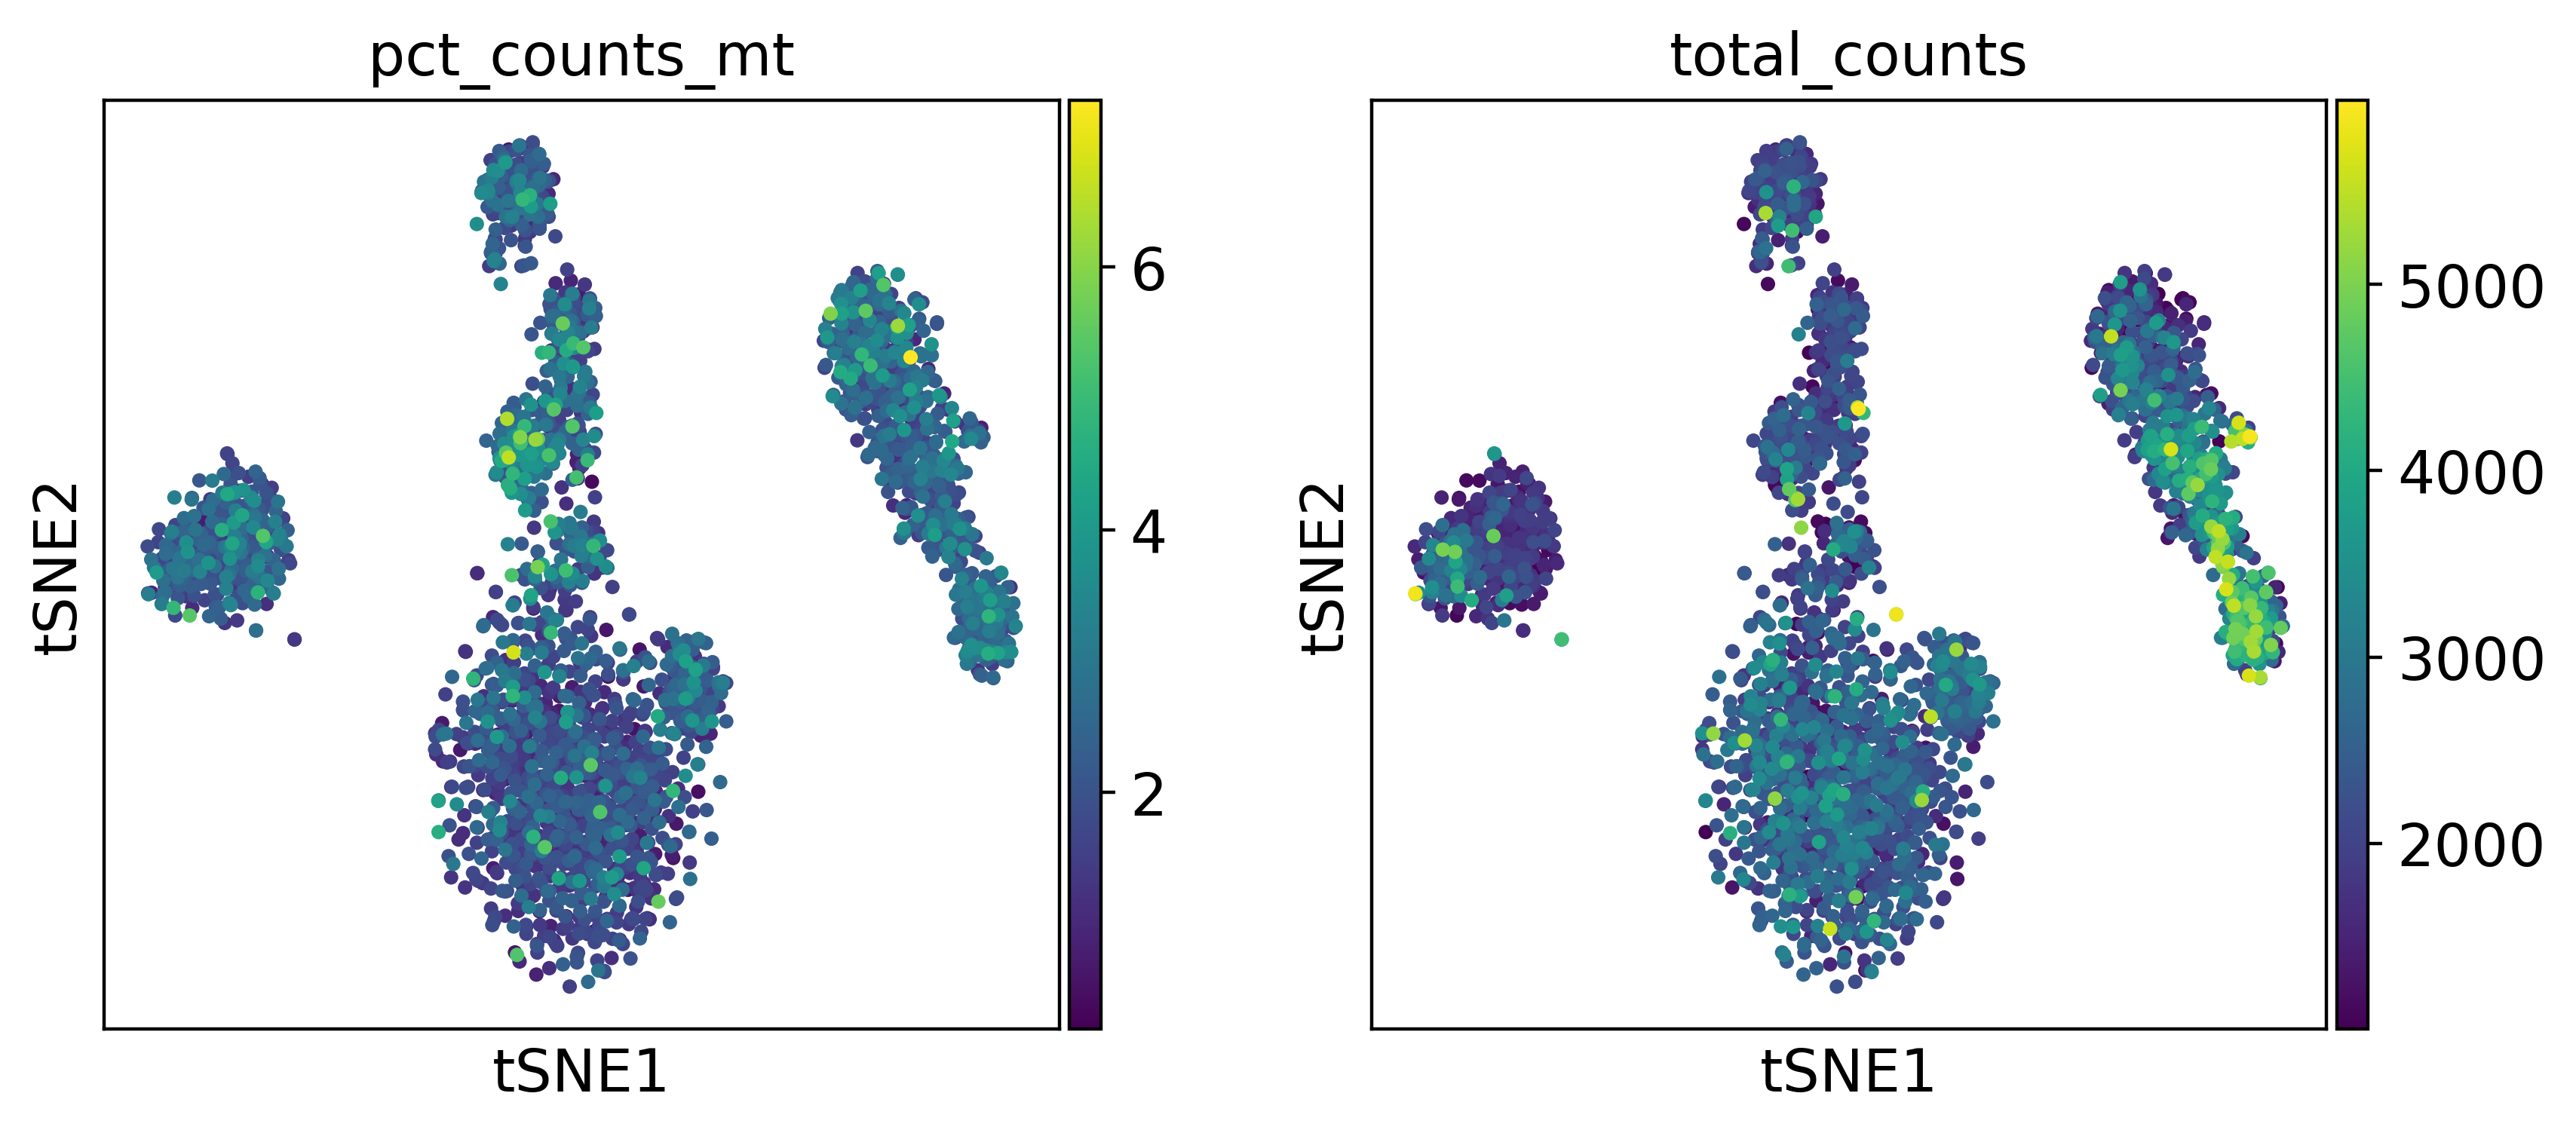

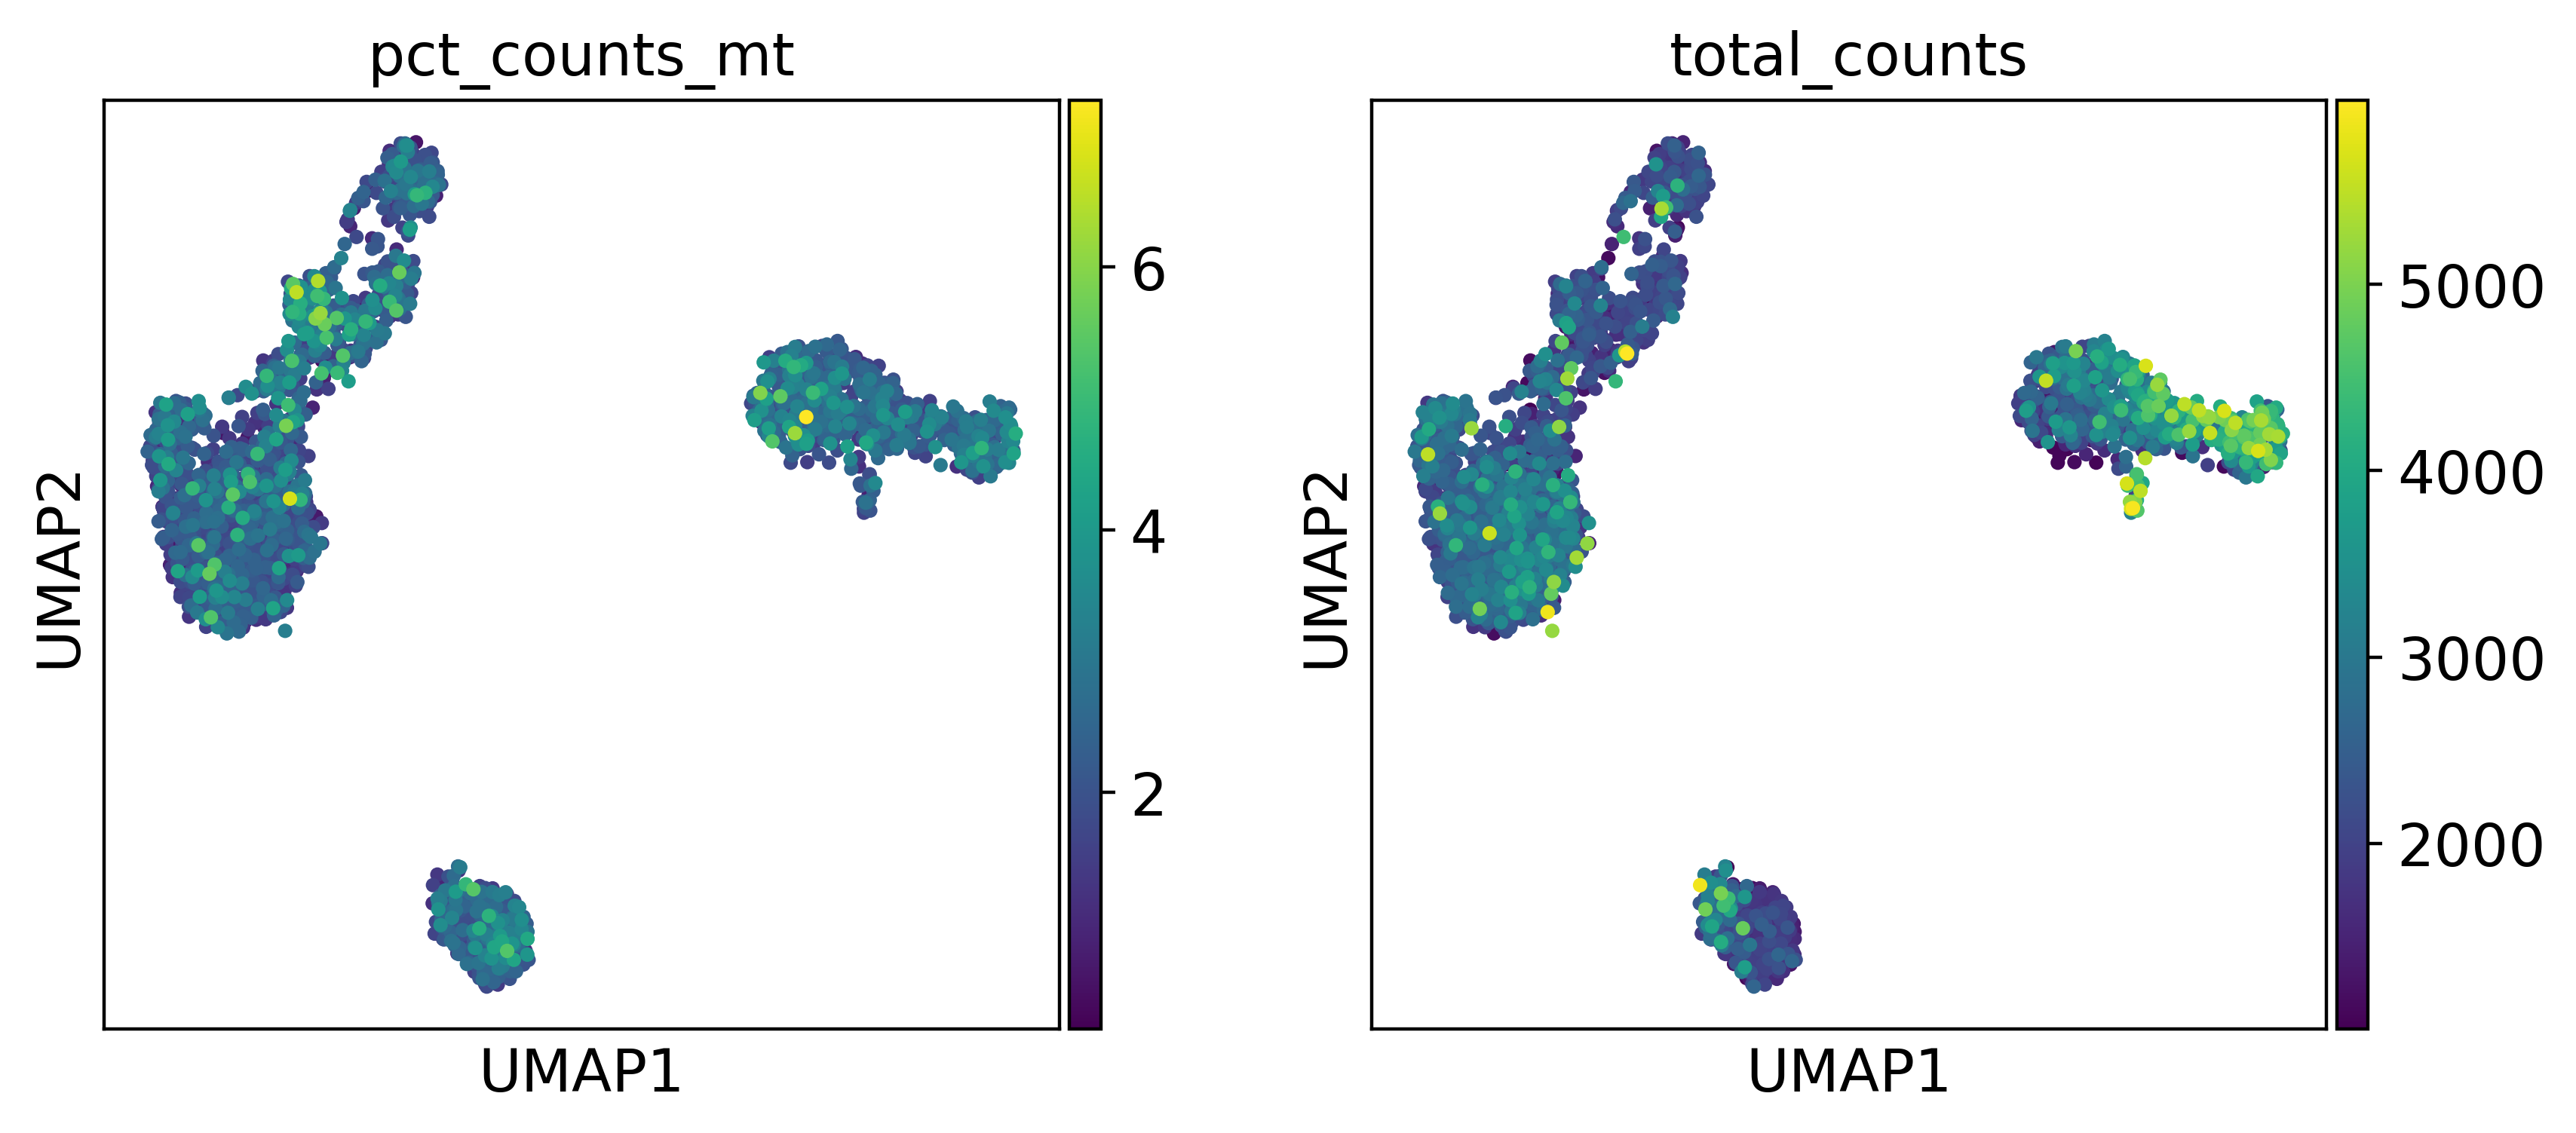

In [23]:
sc.tl.tsne(adata)
sc.tl.umap(adata)
sc.pl.tsne(adata, color=['pct_counts_mt', 'total_counts'])
sc.pl.umap(adata, color=['pct_counts_mt', 'total_counts'])

In [24]:
# After computing different visualizations, you'll now see the coordinates added to the adata object (obsm)
adata

AnnData object with n_obs × n_vars = 2521 × 16470
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [25]:
# Save our preprocessed adata object as a .h5ad file for downstream analysis
adata.write(results)

# 8 Summary

Congrats! You've successfully completed the preprocessing tutorial. In summary, this tutorial introduced you the basic steps and workflow for preprocessing scRNA-seq data. We did some quality control and filtered out cells, normalized our dataset, selected highly variable genes, and calculated several different visualizations of our dataset. Remember there is no "one size fits all" approach to scRNA-seq analysis, but this tutorial should have given you a good general idea of common (and important!) steps and things to consider when processing your own dataset.

We started with an adata object that simply contained cells-by-genes counts matrix. With each step of our preprocessing workflow, we refined our dataset and added new information to our adata object, including:
* a *counts* layer with our raw count data
* log-normalized data in adata.raw
* highly variable gene annotations in adata.var['highly_variable']
* visualization coordinates in adata.obsm

Next up, cluster analysis! Moving forward, we will work with the UMAP projection of our sample dataset, but you are welcome to work with another projection if you'd like.